# Table of content

[1. Setup](#Setup)

[2. Getting a feeling for my data & business understanding](#feeling)

[3. Data cleaning and preparation](#cleaning)


# Setup
<a id='Setup'></a>

In thise section the tequired libraries and dataset will be imported. 55 csv files were loaded and combined into a single data frame using the pd.read_csv function in python.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sms
import copy
import glob

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Image
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# get data file names
path =r'/Users/brittarover/nf-sep-2020/Projekt_2/data'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
       dfs.append(pd.read_csv(filename))
# Concatenate all data into one DataFrame
df = pd.concat(dfs, ignore_index=True)

In [4]:
# take a quick, first look
df.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",28645.0,international
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1950.0,domestic


In [4]:
print('Dimension of the dataset:', df.shape)

Dimension of the dataset: (209222, 37)


# Getting a feeling for my data & business understanding
<a id='feeling'></a>

In this section the we took a closer look on our data and tried to get a better understanding for our business case. 

### Research for business understanding

First of all, we tried to figured out what each column stands for: 

- **backers_count**: number of people who backed a project
- **blurb**: short project description (renamed to projectinformation)
- **category**: category of the kickstarter project
- **converted_pledged_amount**: amount of money that has been pledged to the campaign
- **country**: project country
- **created_at**: date when the project was created 
- **creator**: Project host (name) 
- **currency**: currency (Dollar, Euro etc) 
- **currency_symbol**: currency symbol ($ etc)
- **currency_trailing_code**: trailing code for the dirrent currencies
- **current_currency**: currency 
- **deadline**: deadline for crowdfunding project 
- **disable_communication**: if the communication is disabled or not
- **friends**: maybe backers or followers
- **fx_rate**: actual exchange rate
- **goal**: amount of money needed to be successful
- **id**: project ID 
- **is_backing**: sum of backed projects
- **is_starrable**: gibt nur True and False, unklar was es ist **ToDo** klärung ggf dropen 
- **is_starred**: gibt True, False, viele NaN values, "ist markiert" **ToDo** ggf dropen
- **launched_at**: Wieder nur eine Ziffernfolge, abgleichen mit den anderen möglichen Datums werten **ToDo** Klärung ob Datum, konvertieren? 
- **location**: Dictionarie mit Städten, **ToDo** aufspalten, abgleich mit country welche sinnvoller ist
- **name**: project title **ToDo** check if corr
    - new feature len of project title
- **permissions**: Evtl die die zugelassen wurden, umgestzt **ToDo** abgleich mit friends, und is_backing, 99% empty
- **photo**: Dictionarie, unklar ob das heißt dass ein Foto mit gepostet wurde? **ToDo** Dictionarie aufspalten, anschauen
- **pledged**: Ggf die Summe die gespendet wurde? **ToDo** abgleichen mit goal und converted_pledge_amount
- **profile**: Dictionarie, eine Zusammenfassung vieler features **ToDo** ggf aufspalten und schauen ob sinnvoll oder dorpen
- **slug**: might be a [search enginge text](https://de.ryte.com/wiki/Slug) **ToDo** macht das für uns Sinn? check if redundant with title / project info
- **source_url**: URL zum Projekt **ToDo** anschauen ob wir damit was anfangen können, evtl. drop
- **spotlight**: Nur True and False Werte **ToDo** mit kickstarter Zusammenhang recherchieren, ob es eine spotlight funktion gibt?
- **staff_pick**: Prodiukt Kurzfilm, nur True and False Werte **ToDo** näher anschauen corr()
- **state**: state of the projects - successfull, failed, canceled, live, suspended **ToDo** näher anschauen 
- **state_changed_at**: Date when the project was changed
    - split into year, month, date, time **ToDo** drop changed_at
- **static_usd_rate**: Umrechnungskurs - **ToDo** abgleichen mit fx_rate und currency, Klärung ob wir es brauchen 
- **urls**: maybe again URL **ToDo** Dictionary, abgleichen mit URL wenn gleich ggf eine dropen 
- **usd_pledged**: Scheint eine Summe zu sein, **ToDo** abgleichen mit goal und converted_pledge_amount und pledged 
- **usd_type**: Gibt nur international und domestic, **ToDo** abgleich mit country und location

[Kickstarter Website](https://www.kickstarter.com/about?lang=de)
- launched in 2009
- Kickstarter is a funding platform for creative projects (from films, games, and music to art, design, and technology)
- all-or-nothing model
- Creators are responsible for setting their own financial goal and their fundraising deadline
- campaign can run for just one day or up to 60, but we tend to see 30 days works best
- not able to pause campaigns - but if a creator decides now is not the time for their project, they have the ability to cancel and relaunch at a later date
- Backers are folks who pledge money 
- there is a message function (*only possible to send direct messages between backers and creators*)
- beside supporting a project (“Back this project” button) there is a possibility top follow creators  

[kickstater stats](https://www.kickstarter.com/help/stats?lang=eng)
- Most successfully funded projects raise less than $10,000

[How to get featured on kickstarter](https://www.kickstarter.com/blog/how-to-get-featured-on-kickstarter?lang=de)
- kickstarer does feature exceptional projects
- story telling & eye-catching project page plays a role in which projects we decide to feature 
    - titel, clearly & short project introduction, free of typos
    - project image
    - essential information first, clear statement at the beginning
    - add plenty visually photos, videos, gifs etc
    - show rewards actual or from the past
    - english speaking community
    
[Crowdfunding Secrets: 7 Tips For Kickstarter Success](https://www.forbes.com/sites/amadoudiallo/2014/01/24/crowdfunding-secrets-7-tips-for-kickstarter-success/#51a192056d8d)
- Solve a real problem *You need to be able to tell people right away how the product is going to solve a real problem that they have.* - tell in 1 or 2 sentences. 
    - **ToDo** let's keep an eye on the lenght of name / blurb
- Do your homework *You've got to have an e-commerce site up and running .. build your customer database well before going on Kickstarter .. miss any one of these, and you're dead.* 
    - **ToDo** Are there any hints in the urls?
- Bring money to the table
- Set a smart funding goal 
    - **ToDo** Take a look at the pledged amount
- Make an effective pitch - Videos etc. and Rewards/perks are huge calls to action for potential backers
    - **ToDo** Keep an eye on the medium (jpg/video etc.)
- Importance of the contributor community (feedback) ( social media / e-mail / spreading the word 
    - **ToDo** Check friends & communication function

### Getting a feeling for my data

In [5]:
# check column names
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

In [6]:
# check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 37 columns):
backers_count               209222 non-null int64
blurb                       209214 non-null object
category                    209222 non-null object
converted_pledged_amount    209222 non-null int64
country                     209222 non-null object
created_at                  209222 non-null int64
creator                     209222 non-null object
currency                    209222 non-null object
currency_symbol             209222 non-null object
currency_trailing_code      209222 non-null bool
current_currency            209222 non-null object
deadline                    209222 non-null int64
disable_communication       209222 non-null bool
friends                     300 non-null object
fx_rate                     209222 non-null float64
goal                        209222 non-null float64
id                          209222 non-null int64
is_backing                  300 

In [7]:
# df.nunique()

### Check Null Values

In [8]:
# checking null values
nan = pd.DataFrame(df.isnull().sum(),columns=['Count'])
nan['Percentage'] = round(nan.Count/df.shape[0]*100,1)
nan[nan.Count!=0]

,Count,Percentage
blurb,8,0.0
friends,208922,99.9
is_backing,208922,99.9
is_starred,208922,99.9
location,226,0.1
permissions,208922,99.9
usd_type,480,0.2


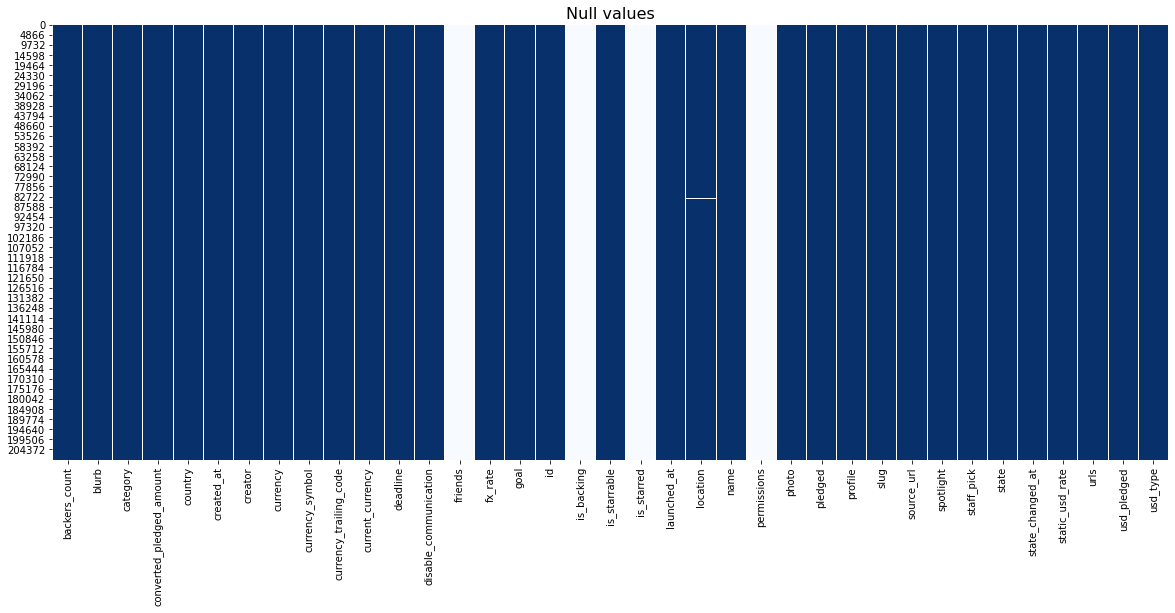

In [9]:
# plot of entries with null values
plt.figure(figsize=(20,8))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues_r');
plt.title('Null values', fontsize=16);

In [10]:
# statistical insights 
df.describe()

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged
count,209222.000000,2.092220e+05,2.092220e+05,2.092220e+05,209222.000000,2.092220e+05,2.092220e+05,2.092220e+05,2.092220e+05,2.092220e+05,209222.000000,2.092220e+05
mean,145.419057,1.289290e+04,1.456089e+09,1.463033e+09,0.994857,4.917604e+04,1.073222e+09,1.460206e+09,1.881403e+04,1.462838e+09,1.010757,1.289213e+04
std,885.967976,8.889414e+04,6.339711e+07,6.305618e+07,0.211654,1.179427e+06,6.198051e+08,6.309029e+07,3.229596e+05,6.290421e+07,0.231893,8.890124e+04
min,0.000000,0.000000e+00,1.240366e+09,1.241334e+09,0.008966,1.000000e-02,8.624000e+03,1.240603e+09,0.000000e+00,1.241334e+09,0.008771,0.000000e+00
25%,4.000000,1.060000e+02,1.413317e+09,1.420607e+09,1.000000,1.500000e+03,5.351054e+08,1.417639e+09,1.100000e+02,1.420485e+09,1.000000,1.060014e+02
50%,27.000000,1.537000e+03,1.457895e+09,1.464754e+09,1.000000,5.000000e+03,1.074579e+09,1.461924e+09,1.556000e+03,1.464709e+09,1.000000,1.537358e+03
75%,89.000000,6.548000e+03,1.511595e+09,1.519437e+09,1.000000,1.500000e+04,1.609369e+09,1.516694e+09,6.887200e+03,1.519366e+09,1.000000,6.550000e+03
max,105857.000000,8.596474e+06,1.552527e+09,1.557721e+09,1.876033,1.000000e+08,2.147476e+09,1.552537e+09,8.103074e+07,1.552537e+09,1.716408,8.596475e+06


### Check for duplicates

In [11]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df[df.duplicated()]))
    print(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


### First Conclusions

**Our Data Frame:** 
- 37 columns and 209222 rows 
- features: Info concerning features / columns see above
- target could be *state* (but only successfull or failed is interesting) oder *is_backing*

**Data types:** - need to keep an eye on / in the end
- object = 20 ['blurb', 'category', 'country', 'creator', 'currency', 'currency_symbol', 'current_currency', 'friends', 'is_backing', 'is_starred', 'location', 'name', 'permissions', 'photo', 'profile', 'slug', 'source_url', 'state', 'urls', 'usd_type']
- float = 5 ['fx_rate', 'goal', 'pledged', 'static_usd_rate', 'usd_pledged']
- int = 7 ['backers_count', 'converted_pledged_amount', 'created_at', 'deadline', 'id', 'launched_at', 'state_changed_at']
- bool = ['currency_trailing_code', 'disable_communication', 'is_starrable', 'spotlight', 'staff_pick']
       
**Null values** 

Only a few NaN: We need to check if we can fill it or better drop.
- blurb = 8 / 0.0%
- location = 226 / 0.1%
- usd_type = 480 / 0.2%

Loads of null values. We need to check if we can drop these columns.
- friends = 208922 / 99.9% 
- is_backing = 208922 / 99.9% 
- is_starred = 208922 / 99.9% 
- permissions = 208922 / 99.9% 

# Data Exploration & Preparation
<a id='cleaning'></a>

In this section we are looking at each variable individually. So we can decide if the features is going to be important or not. And if possible we create new features.

### State (our target variable)

In [12]:
print('No. of projects each state') 
print(df['state'].groupby(df.state).agg('count'))

No. of projects each state
state
canceled        8624
failed         75199
live            7311
successful    117465
suspended        623
Name: state, dtype: int64


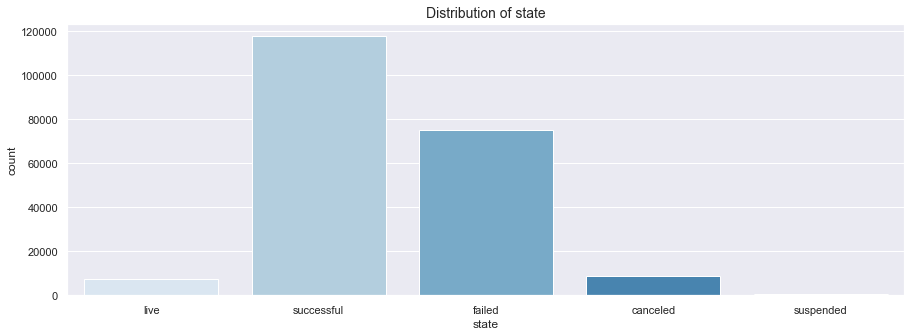

In [13]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x="state", data=df, palette="Blues")
plt.title('Distribution of state', fontsize=14);

In [14]:
# number of success against all
a = (df.state[df.state == 'successful']).count()
c = (df.state[df.state == 'failed']).count()
b = df.state.count()
print("Percantage share of successful projects: " + str(((a/b)*100).round(2)) + "%")
print("Percantage share of failed projects: " + str(((c/b)*100).round(2)) + "%")

Percantage share of successful projects: 56.14%
Percantage share of failed projects: 35.94%


In [28]:
# We only consider the states which can be used for prediction
df.query("state in ['failed','successful']", inplace=True)

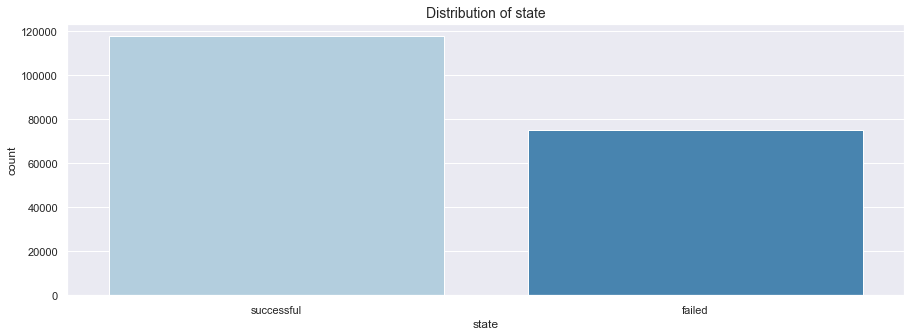

In [16]:
# number of success against all
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x="state", data=df, palette="Blues")
plt.title('Distribution of state', fontsize=14);

a = (df.state[df.state == 'successful']).count()
c = (df.state[df.state == 'failed']).count()
b = df.state.count()

In [17]:
print("Percantage share of successful projects: " + str(((a/b)*100).round(2)) + "%")
print("Percantage share of failed projects: " + str(((c/b)*100).round(2)) + "%")

Percantage share of successful projects: 60.97%
Percantage share of failed projects: 39.03%


In [18]:
# after change of the label state
a=df.nunique()
a.sort_values().head(15)

permissions                0
is_starred                 0
is_backing                 0
friends                    0
is_starrable               1
disable_communication      1
state                      2
staff_pick                 2
spotlight                  2
current_currency           2
usd_type                   2
currency_trailing_code     2
currency_symbol            6
currency                  14
country                   22
dtype: int64

In [5]:
# change of the labelcolumn
df['state_bin']=df['state'].apply(lambda x: 1 if x=='successful' else 0)
df['state_bin'].head()

0    0
1    1
2    1
3    0
4    1
Name: state_bin, dtype: int64

### is_backing , is_starred, is_starrable and permissions

In [20]:
print(df.is_backing.unique())
print(df.is_backing.value_counts())
# delete is_backing: couldnt get any information out of it 

[nan]
Series([], Name: is_backing, dtype: int64)


In [21]:
print(df.is_starred.unique())
print(df.is_starred.value_counts())
# delete is_starred: couldnt get any information out of it 

[nan]
Series([], Name: is_starred, dtype: int64)


In [22]:
print(df.permissions.unique())
print(df.permissions.value_counts())
# delete premissions: couldnt get any information out of it 

[nan]
Series([], Name: permissions, dtype: int64)


In [23]:
print(df.is_starrable.unique())
print(df.is_starrable.value_counts())
#keep - check

[False]
False    192664
Name: is_starrable, dtype: int64


**Comment**
We decided do drop the feature is_backing, is_starred, is_starrable and permissions. All of them don't provide usefull information.

### spotlight 

In [24]:
print(df.spotlight.unique())
print(df.spotlight.value_counts())
# keep

[ True False]
True     117465
False     75199
Name: spotlight, dtype: int64


**Comment**: 
[spotlight](https://help.kickstarter.com/hc/en-us/articles/115005135834-What-is-Spotlight-) seems to be an intereseting feature as its completly filled with true/fales. As we found out online, spotlight allows creators to make a home for their project on Kickstarter after they’ve been successfully funded. S it seems if the information could lead to data leakage, we'll drop it.

#### Plotting spotlight and state

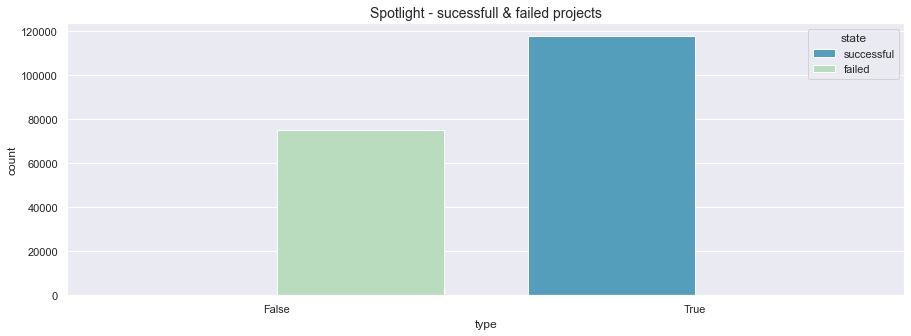

In [25]:
sns.countplot(x='spotlight' ,data=df, hue='state', palette="GnBu_r");
plt.title('Spotlight - sucessfull & failed projects', fontsize=14);
plt.xlabel("type", fontsize=12)
plt.ylabel("count", fontsize=12);

### usd_type

In [26]:
df.usd_type.value_counts()
# keep

domestic         97437
international    95189
Name: usd_type, dtype: int64

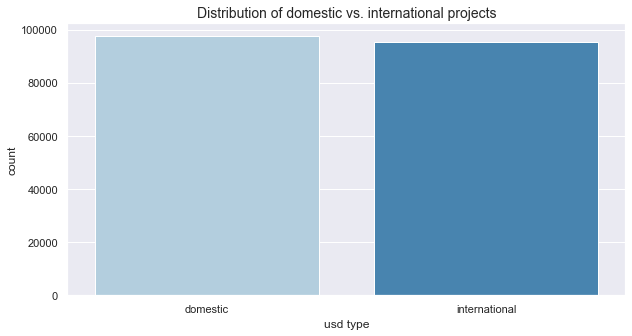

In [27]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x="usd_type", data=df, palette="Blues")
plt.title('Distribution of domestic vs. international projects', fontsize=14);
plt.xlabel("usd type", fontsize=12)
plt.ylabel("count", fontsize=12);

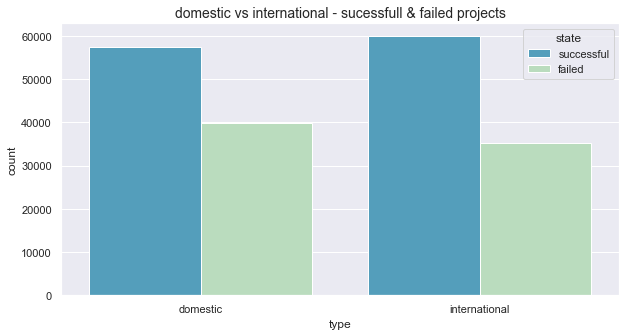

In [28]:
sns.countplot(x='usd_type' ,data=df, hue='state', palette="GnBu_r");
plt.title('domestic vs international - sucessfull & failed projects', fontsize=14);
plt.xlabel("type", fontsize=12)
plt.ylabel("count", fontsize=12);

**Comment** We'll keep the feature "usd_type". 

### Datetimes features: created_at, deadline, launched_at, state_change_at

In the following we explore all the datetime features and changed it to year, month, day and time. 
Additional we've created a new feature project duration, which may also help us for predicting if a kickstarter project is going to be successfull or not. 

Features to be added and in focus are: 
- year launched
- month launched
- day launched
- year deadline
- month deadline 
- day deadline 
- project duration 
- preparation duration

Features created but not in focus: 
- (year / month / day) created
- (year / month / day) state changed at  

In [6]:
# change Date-times deadline
df['deadline'] = pd.to_datetime(df['deadline'], unit='s')

In [7]:
# split date to year and month and delete deadline later 
df['year_deadline'] = df['deadline'].dt.year 
df['month_deadline'] = df['deadline'].dt.month 
df['day_deadline'] = df['deadline'].dt.day
df['time_deadline'] = df['deadline'].dt.time

In [8]:
# change Date-times launched_at
df['launched_at'] = pd.to_datetime(df['launched_at'], unit='s')

In [9]:
# split date to year and month and delete deadline later 
df['year_launched'] = df['launched_at'].dt.year 
df['month_launched'] = df['launched_at'].dt.month 
df['day_launched'] = df['launched_at'].dt.day
df['time_launched'] = df['launched_at'].dt.time

In [10]:
# change Date-times created_at
df['created_at'] = pd.to_datetime(df['created_at'], unit='s')
#print(df.created_at.head(2))

In [11]:
# split date to year and month and delete created_atlater 
df['year_created'] = df['created_at'].dt.year 
df['month_created'] = df['created_at'].dt.month 
df['day_created'] = df['created_at'].dt.day
df['time_created'] = df['created_at'].dt.time

In [12]:
# change Date-times state_changed_at
df['state_changed_at'] = pd.to_datetime(df['state_changed_at'], unit='s')

In [13]:
# split date to year and month and delete state_changed_at later 
df['year_state_changed'] = df['state_changed_at'].dt.year 
df['month_state_changed'] = df['state_changed_at'].dt.month 
df['day_state_changed'] = df['state_changed_at'].dt.day
df['time_state_changed'] = df['state_changed_at'].dt.time

#### Explore datetimes and create new feature: project_duration

In [37]:
print('No. of projects launched per year') 
print(df['year_launched'].groupby(df.year_launched).agg('count'))

No. of projects launched per year
year_launched
2009      221
2010     1365
2011     4083
2012     8447
2013    11119
2014    26414
2015    36828
2016    28858
2017    29682
2018    40942
2019     4705
Name: year_launched, dtype: int64


In [38]:
print('No. of project deadlines per year') 
print(df['year_deadline'].groupby(df.year_deadline).agg('count'))

No. of project deadlines per year
year_deadline
2009      142
2010     1230
2011     3821
2012     8360
2013    10922
2014    25137
2015    36765
2016    29114
2017    29618
2018    40421
2019     7134
Name: year_deadline, dtype: int64


In [39]:
print('Earliest Kickstarter Campaign in the Dataset: ',df.year_created.min())
print('Latest Kickstarter Campaign in the Dataset: ',df.year_created.max())

Earliest Kickstarter Campaign in the Dataset:  2009
Latest Kickstarter Campaign in the Dataset:  2019


In [40]:
# create new feature - preparation_duration (difference in days between created and launched) 
df['preparation_duration'] = df['launched_at'] - df['created_at']
df['preparation_duration_int'] = df['preparation_duration'].apply(lambda x: x.days)

In [41]:
# create new feature - project_duration (difference in days between launched and deadline) 
df['project_duration'] = df['deadline'] - df['launched_at']
df['project_duration_int'] = df['project_duration'].apply(lambda x: x.days)

In [42]:
print(df.project_duration.nlargest(3))
print(df.project_duration.nsmallest(3))

133519   93 days 02:32:04
173758   93 days 02:32:04
95437    92 days 00:00:00
Name: project_duration, dtype: timedelta64[ns]
6557    1 days
6910    1 days
21548   1 days
Name: project_duration, dtype: timedelta64[ns]


In [43]:
print(df.preparation_duration.nlargest(3))
print(df.preparation_duration.nsmallest(3))

68715    3303 days 13:44:00
132442   2593 days 18:00:16
177106   2593 days 18:00:16
Name: preparation_duration, dtype: timedelta64[ns]
150685   00:03:56
145049   00:04:12
84303    00:04:40
Name: preparation_duration, dtype: timedelta64[ns]


In [44]:
print(df.project_duration.describe())
print(df.preparation_duration.describe())

count                     192664
mean     32 days 09:26:15.410637
std      11 days 15:32:10.459356
min              1 days 00:00:00
25%             29 days 23:00:00
50%             30 days 00:00:00
75%      33 days 14:58:05.250000
max             93 days 02:32:04
Name: project_duration, dtype: object
count                      192664
mean      47 days 13:35:30.819052
std      130 days 02:00:39.623547
min               0 days 00:03:56
25%        2 days 23:42:17.500000
50%       11 days 09:12:06.500000
75%              36 days 20:17:50
max            3303 days 13:44:00
Name: preparation_duration, dtype: object


In [45]:
print('Shortest project duration from launch to deadline: ', df.project_duration.min())
print('Longest project duration from launch to deadline: ', df.project_duration.max())

Shortest project duration from launch to deadline:  1 days 00:00:00
Longest project duration from launch to deadline:  93 days 02:32:04


In [46]:
# group the month and state to find out which one might be successful or not
df_suc_month = df.groupby(["month_created","state"])['state'].count()

In [47]:
df_suc_month.nsmallest(3)

month_created  state 
12             failed    4672
2              failed    5935
11             failed    6004
Name: state, dtype: int64

**Comment** 
A we can see, the project duraiton is from minimum 1 day up to 93 days. Following we'll get a better understanding for our datetimes by making different plots. 

#### Plotting project_duration

In [48]:
# make bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df['pd_bins'] = pd.cut(df['project_duration_int'], bins)

In [49]:
df.pd_bins.value_counts()

(20, 30]     111767
(30, 40]      27320
(50, 60]      17925
(10, 20]      16837
(40, 50]      13474
(0, 10]        4771
(80, 90]        308
(60, 70]        159
(70, 80]         93
(90, 100]        10
Name: pd_bins, dtype: int64

In [50]:
# sns.set(rc={'figure.figsize':(15,5)})
# sns.countplot(x="project_duration_int", data=df, palette="Blues")
# plt.title('Distribution of duration days');

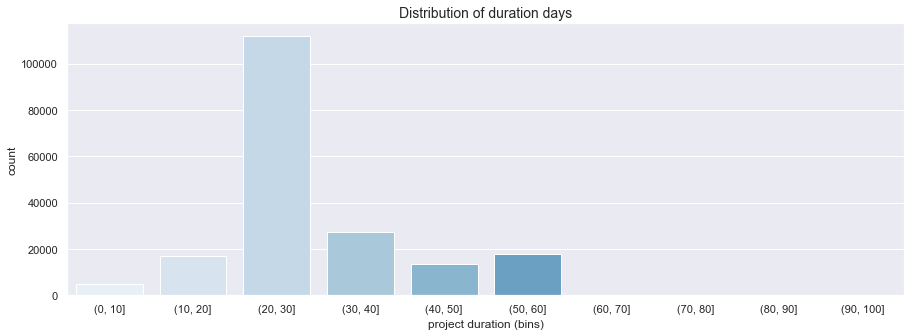

In [51]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x= df.pd_bins, data=df, palette="Blues")
plt.title('Distribution of duration days', fontsize=14)
plt.xlabel("project duration (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

In [52]:
project_duration = df.groupby(['project_duration_int','state'])['project_duration_int'].count().reset_index(name='count')
project_duration["sum_counts"] = project_duration.groupby('project_duration_int')['count'].transform('sum')
project_duration["percent"] = project_duration['count']/project_duration["sum_counts"]
project_duration = project_duration[project_duration['state'] == 'successful']
project_duration.head()

,project_duration_int,state,count,sum_counts,percent
1,1,successful,49,88,0.556818
3,2,successful,57,88,0.647727
5,3,successful,85,143,0.594406
7,4,successful,89,148,0.601351
9,5,successful,235,334,0.703593


<Figure size 1800x600 with 0 Axes>

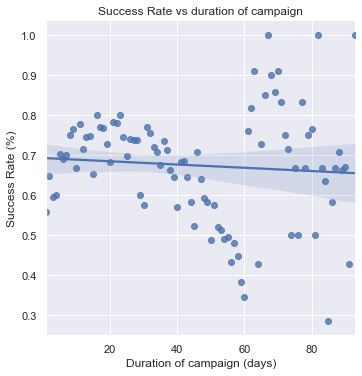

In [53]:
plt.figure(dpi=120)
sns.lmplot(data=project_duration, x="project_duration_int", y="percent")
plt.title("Success Rate vs duration of campaign", fontsize=12)
plt.xlabel("Duration of campaign (days)")
plt.ylabel("Success Rate (%)")
plt.show()

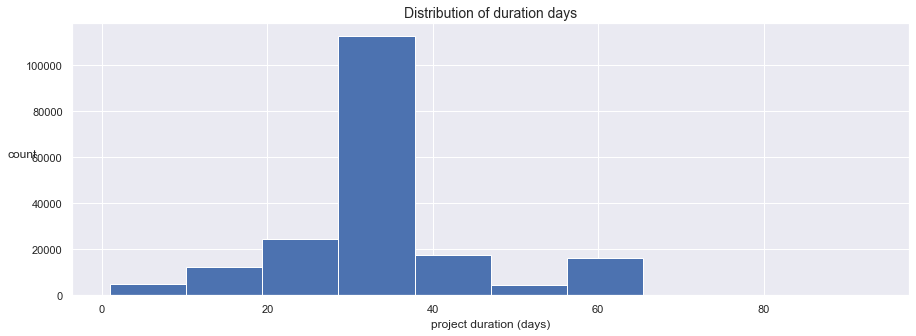

In [54]:
df['project_duration'].dt.days.hist();
plt.title('Distribution of duration days', fontsize=14)
plt.xlabel("project duration (days)", fontsize=12)
plt.ylabel("count", rotation=0, fontsize=12);

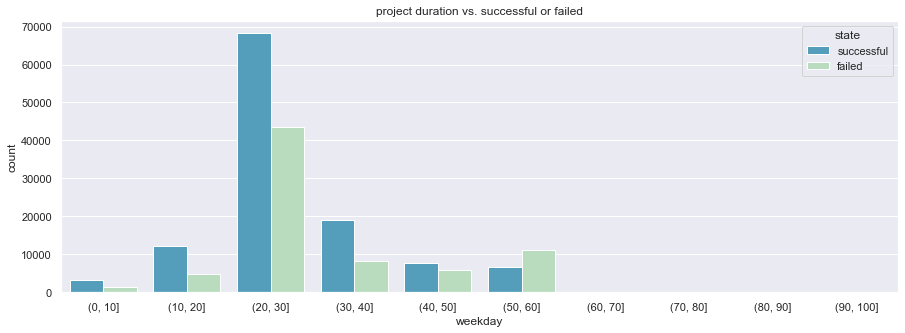

In [55]:
sns.countplot(x=df.pd_bins, data=df, hue='state', palette="GnBu_r")
plt.title('project duration vs. successful or failed')
plt.xlabel("weekday")
plt.ylabel("count");

#### Plotting preparation duration

In [56]:
# make bins
df.prep_bins = pd.cut(df['preparation_duration'], bins=10)

In [57]:
df.preparation_duration_int.nsmallest()

10    0
22    0
26    0
30    0
47    0
Name: preparation_duration_int, dtype: int64

#### Plotting datetimes focused on year

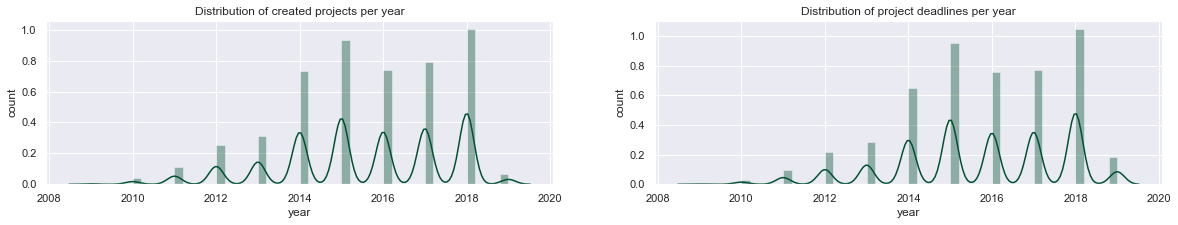

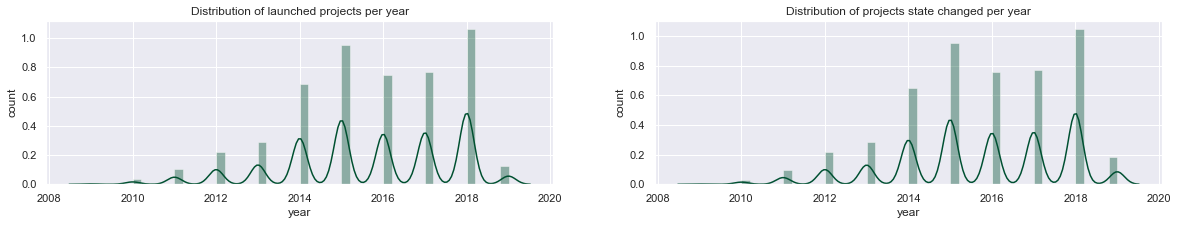

In [58]:
# histogram to explore a single variable (distribution)
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.distplot(df.year_created,color='#005030')
plt.title('Distribution of created projects per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.distplot(a=df.year_deadline,color='#005032')
plt.title('Distribution of project deadlines per year')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.distplot(df.year_launched,color='#005030')
plt.title('Distribution of launched projects per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.distplot(a=df.year_state_changed,color='#005032')
plt.title('Distribution of projects state changed per year')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

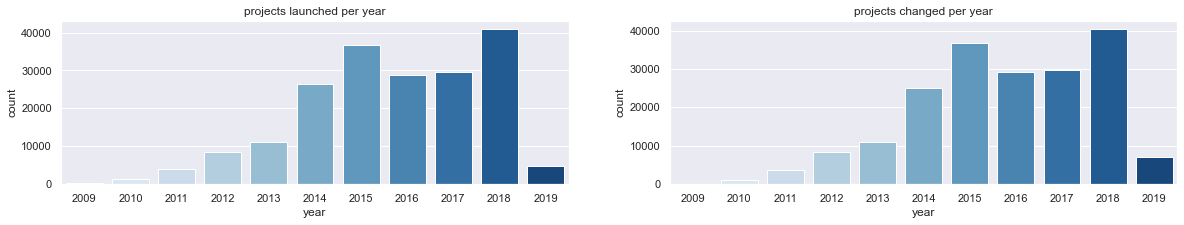

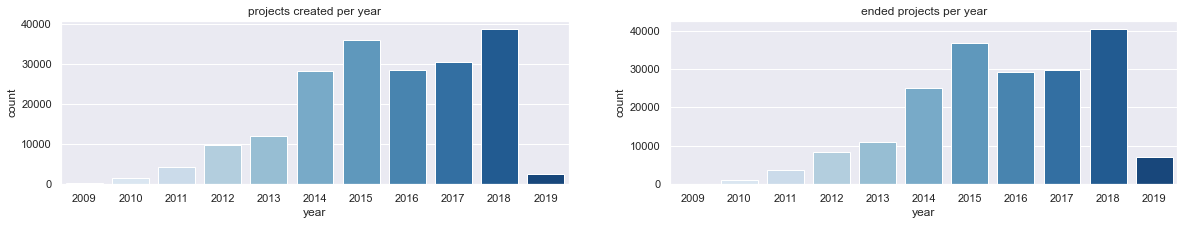

In [59]:
# histogram to explore a single variable (distribution)
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="year_launched", data=df, palette="Blues")
plt.title('projects launched per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="year_state_changed", data=df, palette="Blues")
plt.title('projects changed per year')
plt.xlabel("year")
plt.ylabel("count");

plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="year_created", data=df, palette="Blues")
plt.title('projects created per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="year_deadline", data=df, palette="Blues")
plt.title('ended projects per year')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

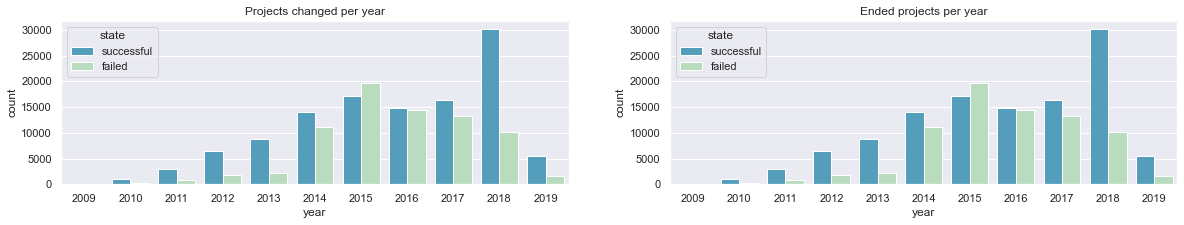

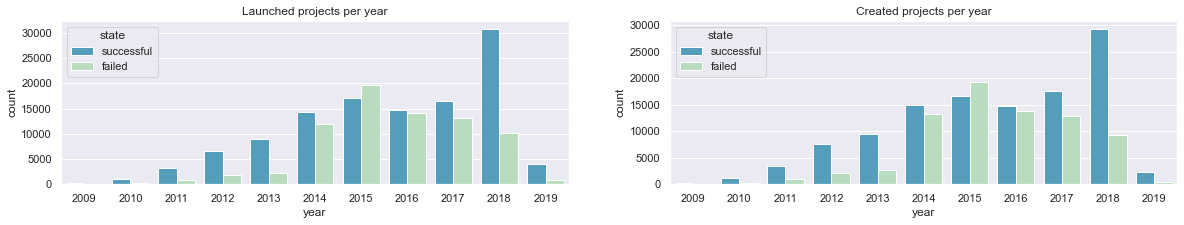

In [60]:
# histogram to explore a single variable (distribution)
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="year_state_changed", data=df, hue='state', palette="GnBu_r")
plt.title('Projects changed per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="year_deadline", data=df, hue='state', palette="GnBu_r")
plt.title('Ended projects per year')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="year_launched", data=df, hue='state', palette="GnBu_r")
plt.title('projects launched per year')
plt.title('Launched projects per year')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="year_created", data=df, hue='state', palette="GnBu_r")
plt.title('projects created per year')
plt.title('Created projects per year')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

In [61]:
# state grouped by year
suc_year_df = df.set_index('launched_at').state
suc_year_df = pd.get_dummies(suc_year_df).resample('YS').sum()

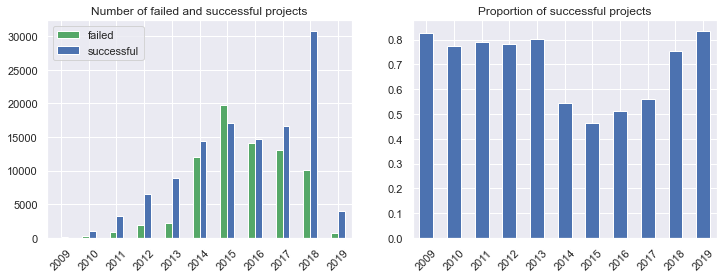

In [62]:
# Plotting the number and proportion of failed and successful projects each year
fig, ax = plt.subplots(1,2, figsize=(12,4))

suc_year_df.plot.bar(ax=ax[0], color=['g', 'b'])
ax[0].set_title('Number of failed and successful projects')
ax[0].set_xlabel('')
ax[0].set_xticklabels(list(range(2009,2020)), rotation=45)

suc_year_df.div(suc_year_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax[1], color='b') # Normalizes counts across rows
ax[1].set_title('Proportion of successful projects')
ax[1].set_xlabel('')
ax[1].set_xticklabels(list(range(2009,2020)), rotation=45)

plt.show()

#### Plotting datetimes focused on month 

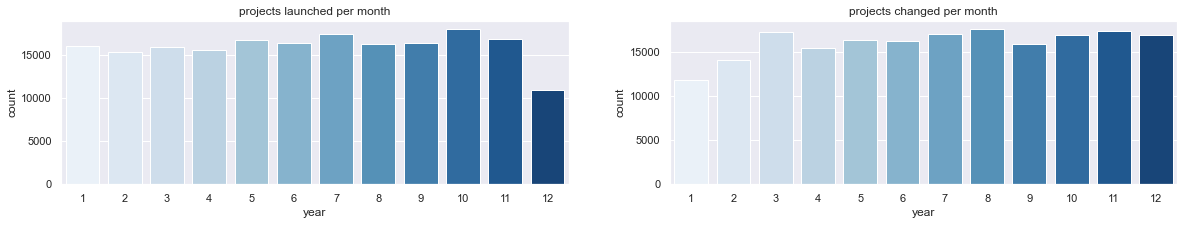

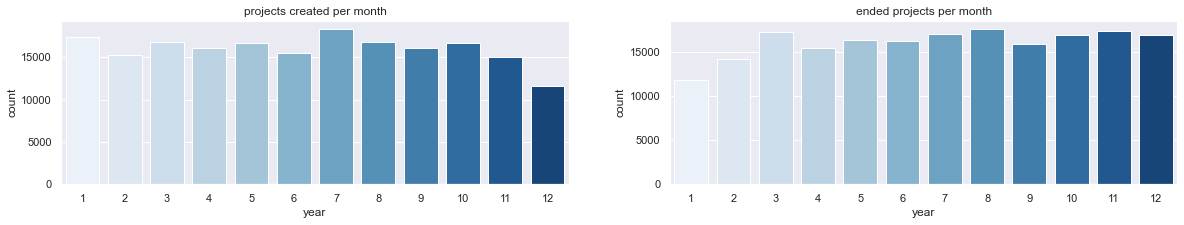

In [63]:
# histogram to explore a single variable (distribution)
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="month_launched", data=df, palette="Blues")
plt.title('projects launched per month')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="month_state_changed", data=df, palette="Blues")
plt.title('projects changed per month')
plt.xlabel("year")
plt.ylabel("count");

plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="month_created", data=df, palette="Blues")
plt.title('projects created per month')
plt.xlabel("year")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="month_deadline", data=df, palette="Blues")
plt.title('ended projects per month')
plt.xlabel("year")
plt.ylabel("count");
plt.show()

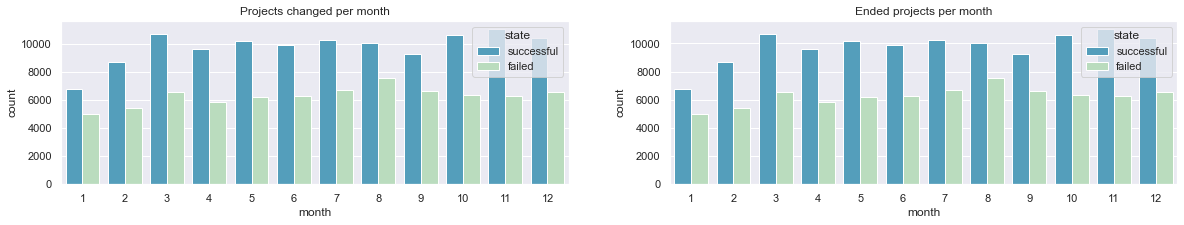

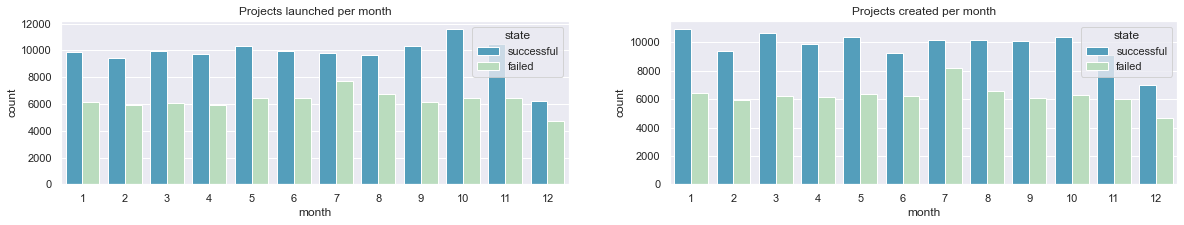

In [64]:
# histogram to explore a single variable (distribution)
plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="month_state_changed", data=df, hue='state', palette="GnBu_r")
plt.title('Projects changed per month')
plt.xlabel("month")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="month_deadline", data=df, hue='state', palette="GnBu_r")
plt.title('Ended projects per month')
plt.xlabel("month")
plt.ylabel("count");
plt.show()

plt.figure(figsize=(20,3))

plt.subplot(1,2,1)
sns.countplot(x="month_launched", data=df, hue='state', palette="GnBu_r")
plt.title('Projects launched per month')
plt.xlabel("month")
plt.ylabel("count");

plt.subplot(1,2,2)
sns.countplot(x="month_created", data=df, hue='state', palette="GnBu_r")
plt.title('Projects created per month')
plt.xlabel("month")
plt.ylabel("count");
plt.show()

In [65]:
# groupe by day launched, with columns for failed and successful
suc_month_df = pd.get_dummies(df.set_index('month_launched').state).groupby('month_launched').sum()

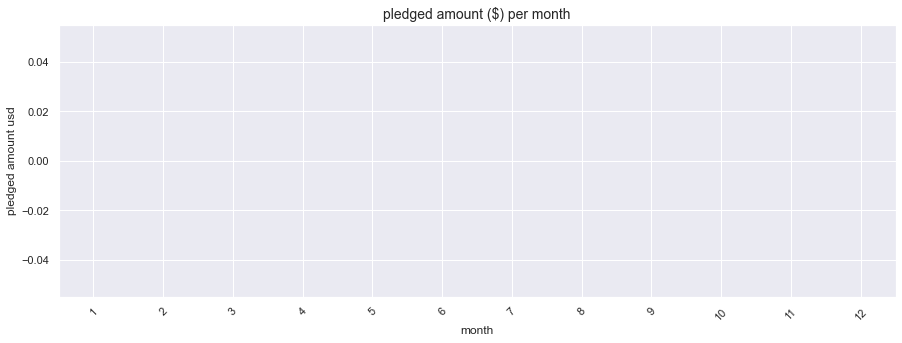

In [66]:
month = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
df.groupby('month_launched').usd_pledged.median().reindex(month).plot(kind='bar', color="b", rot=45)
plt.xlabel('month', fontsize=12)
plt.ylabel('pledged amount usd', fontsize=12)
plt.title('pledged amount ($) per month', fontsize=14)
plt.show()

#### New feature: day_launched (weekday)

In [67]:
# Launch day of week
df['day_launched'] = df['launched_at'].dt.weekday_name

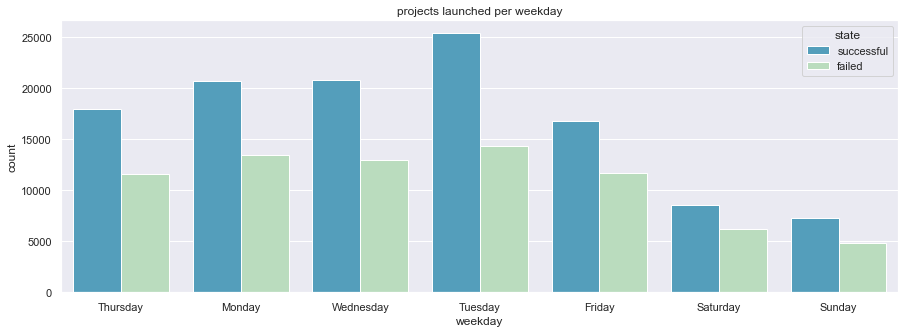

In [68]:
sns.countplot(x=df.day_launched, data=df, hue='state', palette="GnBu_r")
plt.title('projects launched per weekday')
plt.xlabel("weekday")
plt.ylabel("count");

In [69]:
df_suc_day = df.groupby(["day_launched","state"])['state'].count()

In [70]:
print(df['day_launched'].groupby(df.day_launched).agg('count'))

day_launched
Friday       28500
Monday       34135
Saturday     14807
Sunday       12134
Thursday     29531
Tuesday      39755
Wednesday    33802
Name: day_launched, dtype: int64


In [71]:
df_suc_day

day_launched  state     
Friday        failed        11722
              successful    16778
Monday        failed        13416
              successful    20719
Saturday      failed         6248
              successful     8559
Sunday        failed         4875
              successful     7259
Thursday      failed        11602
              successful    17929
Tuesday       failed        14370
              successful    25385
Wednesday     failed        12966
              successful    20836
Name: state, dtype: int64

In [72]:
# groupe by day launched, with columns for failed and successful
suc_day_df = pd.get_dummies(df.set_index('day_launched').state).groupby('day_launched').sum()

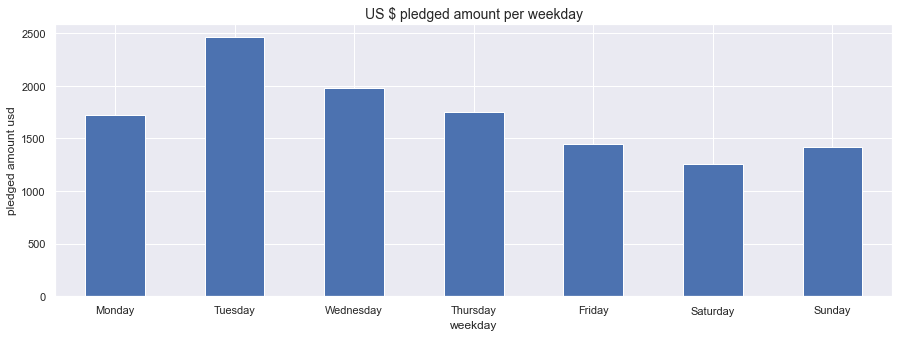

In [73]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby('day_launched').usd_pledged.median().reindex(weekdays).plot(kind='bar', color="b", rot=0)
plt.xlabel('weekday', fontsize=12)
plt.ylabel('pledged amount usd', fontsize=12)
plt.title('US $ pledged amount per weekday', fontsize=14)
plt.show()

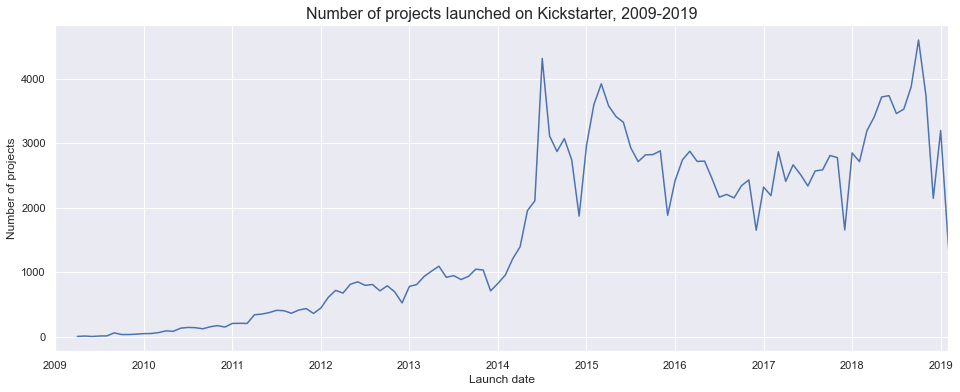

In [74]:
# Plotting the number of projects launched each year
plt.figure(figsize=(16,6))
df.set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2019-02-28') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2019', fontsize=16)
plt.show()

**Comment** 
As we can see, the best day to launch a project is on tuesday. 

### goal

In [75]:
df.goal.head(3)

1     1000.0
2    15000.0
3    10000.0
Name: goal, dtype: float64

In [76]:
df.goal.nlargest(3)

2210     100000000.0
14358    100000000.0
23283    100000000.0
Name: goal, dtype: float64

In [77]:
df.goal.nsmallest(3)

142752    0.01
2213      1.00
2390      1.00
Name: goal, dtype: float64

In [14]:
# creating a new feature goal_usd
df["goal_usd"]=df["goal"]*df["static_usd_rate"]
df["goal_usd_log"]=np.log(df.goal_usd)

In [79]:
# make bins 
df.goal_bins = pd.cut(df['goal'], bins = 5)

In [80]:
# make bins 
goal_bins = np.arange(0, 100000,10000)
goal_series = pd.cut(df['goal_usd'], bins=goal_bins, 
                              labels=goal_bins[:-1])
goal_series.name = 'goal_bin'
goal_df = pd.concat([df, goal_series], axis=1)

In [81]:
# plot 
# sns.set(rc={'figure.figsize':(15,5)})
#sns.countplot(x=df.goal_bins,data=df, hue='state', palette="GnBu_r")
#plt.title('Goal distribution (bins)', fontsize=14)
#plt.xlabel("goal", fontsize=12)
#plt.ylabel("count", fontsize=12);

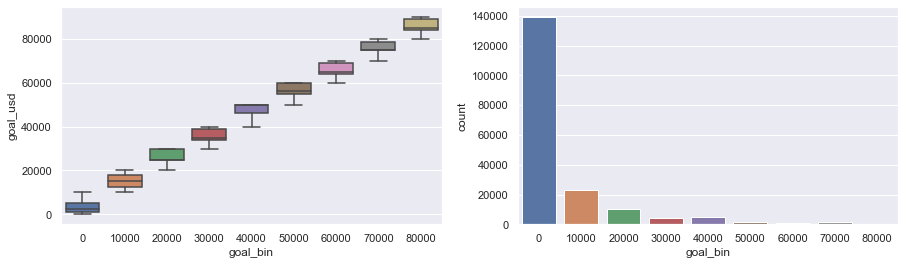

In [82]:
fig,ax=plt.subplots(ncols=2,figsize=(15,4))
sns.countplot(x='goal_bin',data=goal_df,ax=ax[1])
sns.boxplot(x='goal_bin', y='goal_usd', data=goal_df,ax=ax[0])
plt.show()

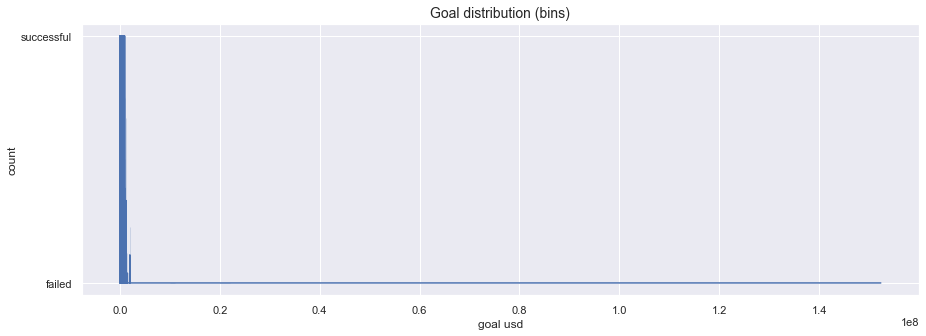

In [83]:
sns.lineplot(data=df, x="goal_usd", y="state")
plt.title('Goal distribution (bins)', fontsize=14)
plt.xlabel("goal usd", fontsize=12)
plt.ylabel("count", fontsize=12);

In [84]:
df_goal=df.query('goal_usd<100000')

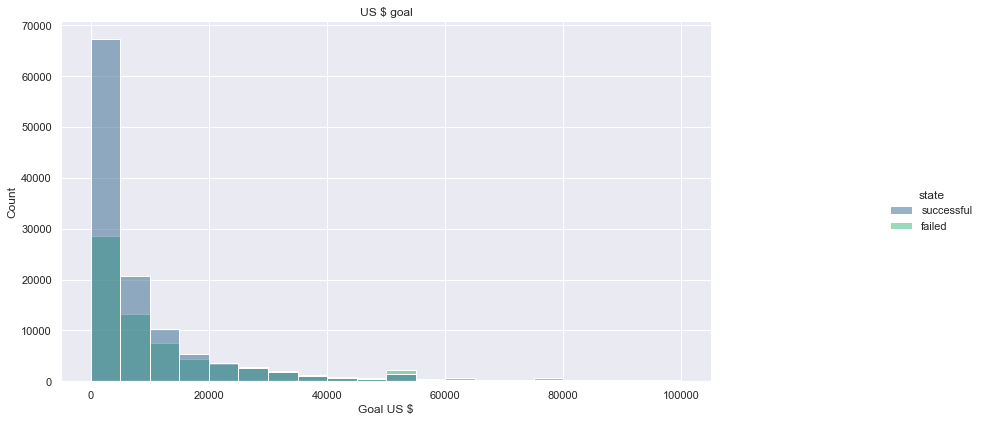

In [85]:
g=sns.displot(df_goal, x="goal_usd",hue='state', bins=20, palette="viridis")
g.fig.set_size_inches(15,6)
plt.title('US $ goal')
plt.xlabel("Goal US $")
plt.ylabel("Count");

In [86]:
df_goal=df.groupby(["goal_usd","state"])['state'].count()

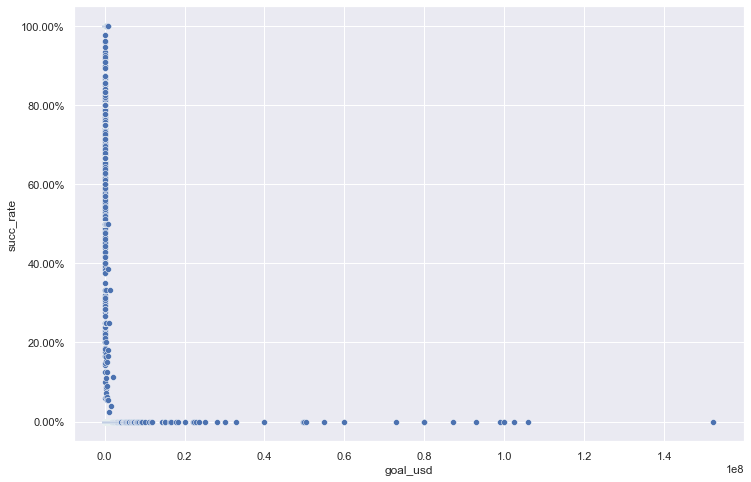

In [87]:
df_goal=df_goal.unstack()
df_goal=df_goal.fillna(0)
df_goal

df_goal["succ_rate"]=df_goal["successful"]/(df_goal["successful"]+df_goal["failed"])
plot=df_goal['succ_rate'][0:500]
df_goaldf=pd.DataFrame(df_goal[0:501])

f,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_goal["succ_rate"])
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'. format(x) for x in vals])


plt.show()

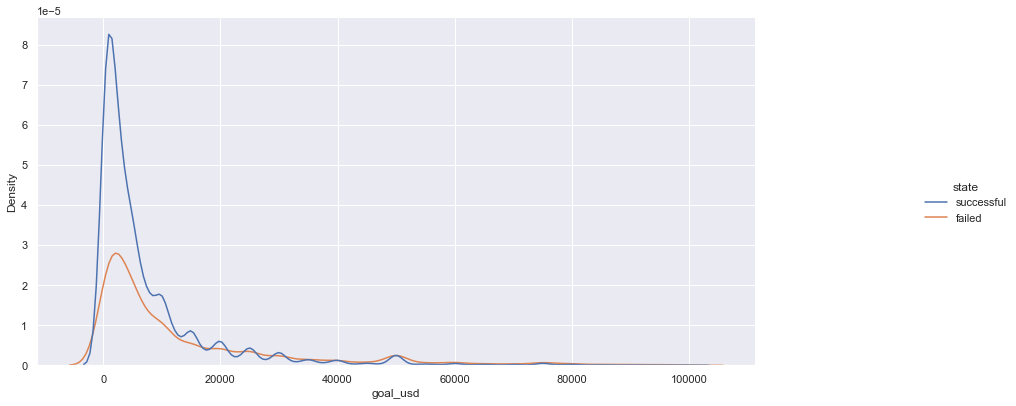

In [88]:
df_goal_new=df.query('goal_usd<100000')
g=sns.displot(df_goal_new, x="goal_usd",hue='state', kind='kde')
g.fig.set_size_inches(15,6)

**Finding** A lower goal ist better. Most of the successfull projects had a goal up to max. 20.000 US $. 

### category

The column category contains data which seems to be in a dictionary. First of all we need to split that column to get a better overview. Finally we extraced some new features maincategory and subcategory.

In [20]:
# split column category
import ast
df_cat = (pd.DataFrame(df['category'].apply(ast.literal_eval).values.tolist()))

In [21]:
df_cat.head(2)

,color,id,name,parent_id,position,slug,urls
0,16752598,266,Footwear,9.0,5,fashion/footwear,{'web': {'discover': 'http://www.kickstarter.c...
1,51627,273,Playing Cards,12.0,4,games/playing cards,{'web': {'discover': 'http://www.kickstarter.c...


In [22]:
# create a new column: category_name
df["category_name"]=df_cat.name
df.category_name.head()

0         Footwear
1    Playing Cards
2             Rock
3    Playing Cards
4       Nonfiction
Name: category_name, dtype: object

In [23]:
# new column maincategory
df["maincategory"]=df_cat.parent_id
df.maincategory.fillna(0,inplace=True)
df.maincategory.astype(int)

0          9
1         12
2         14
3         12
4         18
5         14
6         14
7          0
8         17
9          9
10        10
11        18
12         1
13        14
14        17
15        18
16        17
17        15
18        10
19        17
20        18
21         9
22        14
23        18
24         1
25         0
26         9
27         0
28        10
29        14
          ..
209192    12
209193    11
209194    12
209195    14
209196    17
209197    11
209198    10
209199    13
209200    12
209201    14
209202    13
209203    17
209204    18
209205    16
209206    14
209207    12
209208    14
209209     0
209210    18
209211    12
209212    12
209213    14
209214    11
209215    13
209216    14
209217    12
209218    14
209219    16
209220    11
209221     0
Name: maincategory, Length: 209222, dtype: int64

In [24]:
df['maincategory_name']=df.maincategory.apply(lambda x: "Art" if x==1 else "Comics" if x==3 else "Dance" if x==6 else
                                              "Design" if x==7 else "Fashion" if x==9 else "Food" if x==10 else "Film_Video" if x==11 else
                                              "Games" if x==12 else "Journalism" if x==13 else "Music" if x==14 else "Photography" 
                                              if x==15 else
                                              "Technology" if x==16 else "Theater" if x==17 else "Publisihing" if x==18 else
                                              "Crafts" if x==26 else "Other")

In [25]:
df.maincategory_name.value_counts()

Film_Video     27402
Music          26529
Technology     20772
Publisihing    19899
Art            19628
Food           15676
Games          13940
Fashion        11870
Other           9041
Design          8636
Comics          8430
Photography     7475
Theater         6299
Crafts          5962
Journalism      5098
Dance           2565
Name: maincategory_name, dtype: int64

In [26]:
df.groupby(['maincategory_name','category_name'])['state'].agg(['count'])

count
maincategory_name category_name           
Art               Ceramics             400
                  Conceptual Art      1166
                  Digital Art         1856
                  Illustration        2982
                  Installations        633
                  Mixed Media         2547
                  Painting            2501
                  Performance Art     2363
                  Public Art          2497
                  Sculpture           2042
                  Textiles             395
                  Video Art            246
Comics            Anthologies          727
                  Comic Books         3457
                  Events               225
                  Graphic Novels      2992
                  Webcomics           1029
Crafts            Candles              596
                  Crochet              233
                  DIY                 1557
                  Embroidery           162
                  Glass                195
                  Knitting             323
                  Pottery              209
                  Printing             331
                  Quilts               109
                  Stationery           381
                  Taxidermy             18
                  Weaving              140
                  Woodworking         1708
...                                    ...
Publisihing       Literary Spaces      114
                  Nonfiction          2711
                  Periodicals         1409
                  Poetry              1640
                  Radio & Podcasts    1145
                  Translations         187
                  Young Adult         1001
                  Zines                579
Technology        3D Printing          889
                  Apps                2606
                  Camera Equipment     613
                  DIY Electronics     1256
                  Fabrication Tools    322
                  Flight               460
                  Gadgets             2919
                  Hardware            2640
                  Makerspaces          285
                  Robots               740
                  Software            2509
                  Sound               1008
                  Space Exploration    401
                  Wearables           1641
                  Web                 2483
Theater           Comedy               291
                  Experimental         626
                  Festivals            867
                  Immersive            567
                  Musical             1410
                  Plays               2238
                  Spaces               300

[169 rows x 1 columns]

In [27]:
success_by_subcategory_name = pd.pivot_table(df, index='category_name', columns='state', values='goal_usd', aggfunc='count', fill_value = 0)
success_by_subcategory_name['total'] = success_by_subcategory_name['failed'] + success_by_subcategory_name['successful'] 
success_by_subcategory_name['success_rate'] = success_by_subcategory_name['successful'] / success_by_subcategory_name['total']
topsubcategories = success_by_subcategory_name.sort_values(by='success_rate').reset_index()

In [ ]:
topsubcategories.tail(10)

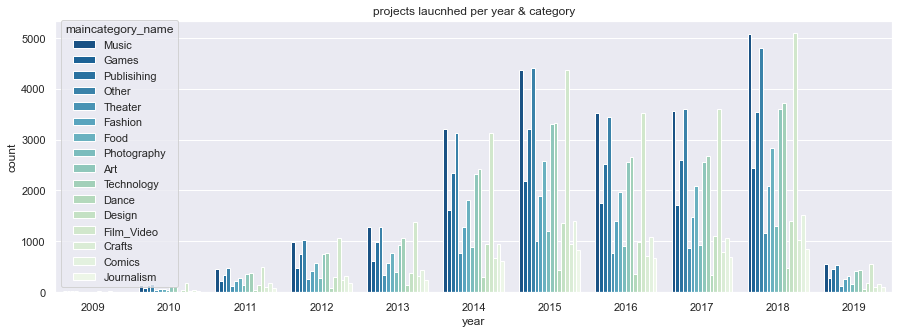

In [98]:
sns.countplot(x="year_launched", data=df, hue=df.maincategory_name, palette="GnBu_r")
plt.title('projects laucnhed per year & category')
plt.xlabel("year")
plt.ylabel("count");

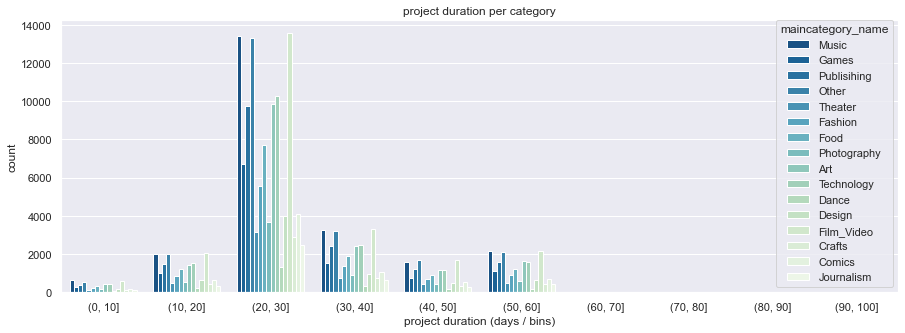

In [99]:
sns.countplot(x=df.pd_bins, data=df, hue='maincategory_name', palette="GnBu_r")
plt.title('project duration per category')
plt.xlabel("project duration (days / bins)")
plt.ylabel("count");

#### Plotting distribution maincategory and success rate per category

In [100]:
# Breaking down success by category
project_category = df.groupby(['maincategory_name','state'])['maincategory_name'].count().reset_index(name='count')
project_category["sum_counts"] = project_category.groupby('maincategory_name')['count'].transform('sum')
project_category["percent"] = project_category['count']/project_category["sum_counts"]
project_category = project_category[project_category['state'] == 'successful']
project_category

,maincategory_name,state,count,sum_counts,percent
1,Art,successful,10326,16971,0.608450
3,Comics,successful,4342,7192,0.603726
5,Crafts,successful,3076,4955,0.620787
7,Dance,successful,1354,2266,0.597529
9,Design,successful,4128,6845,0.603068
11,Fashion,successful,6046,9687,0.624135
13,Film_Video,successful,14400,23412,0.615069
15,Food,successful,8057,13296,0.605972
17,Games,successful,6947,11427,0.607946
19,Journalism,successful,2578,4280,0.602336


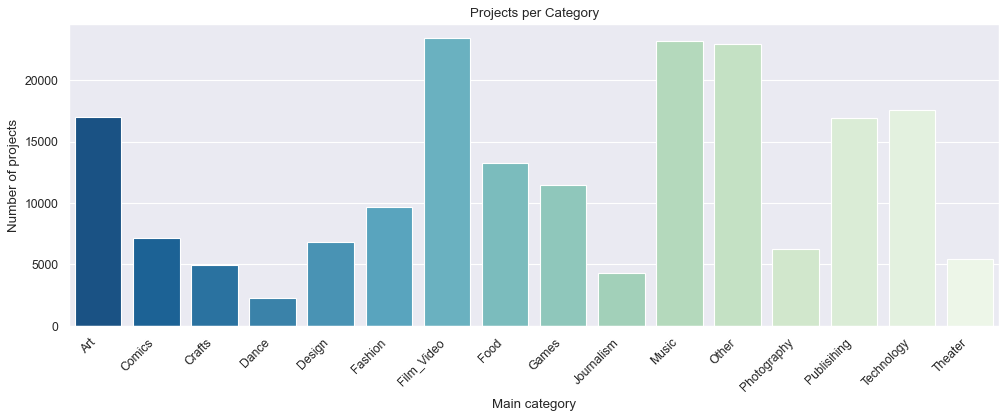

In [101]:
plt.figure(dpi=80)

chart=sns.barplot(data=project_category, x="maincategory_name", y="sum_counts",palette='GnBu_r')
plt.title("Projects per Category", fontsize=12)
plt.xlabel("Main category")
plt.ylabel("Number of projects")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

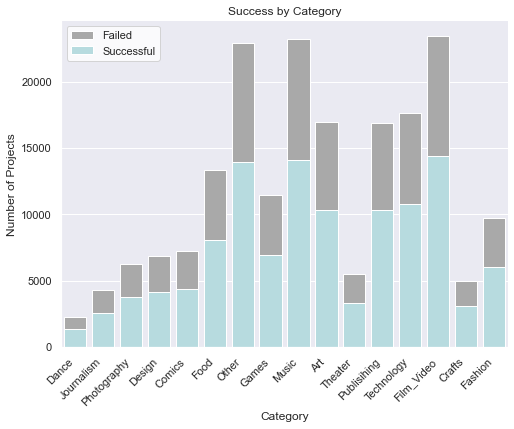

In [102]:
# Breaking down success by category
success_by_category_name = pd.pivot_table(df, index='maincategory_name', columns='state', values='goal_usd', aggfunc='count', fill_value = 0)
success_by_category_name['total'] = success_by_category_name['failed'] + success_by_category_name['successful'] 
success_by_category_name['success_rate'] = success_by_category_name['successful'] / success_by_category_name['total']
topcategories = success_by_category_name.sort_values(by='success_rate').reset_index()

f, ax = plt.subplots(figsize=(8, 6))
sns.set_style("whitegrid")
chart1=sns.barplot(x="maincategory_name",y='total', data=topcategories, label="Failed", color="darkgray")
chart=sns.barplot(x="maincategory_name",y="successful",  data=topcategories, label="Successful", color='powderblue')
sns.despine(trim=False)

plt.title("Success by Category")
plt.ylabel("Number of Projects")
plt.xlabel("Category")
chart1.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend()
plt.show()

####  Plotting Successrate and subcategory

In [103]:
# Breaking down success by subcategory
#success_by_subcategory_name = pd.pivot_table(df, index='category_name', columns='state', values='goal_usd', aggfunc='count', fill_value = 0)
#success_by_subcategory_name['total'] = success_by_subcategory_name['failed'] + success_by_subcategory_name['successful'] 
#success_by_subcategory_name['success_rate'] = success_by_subcategory_name['successful'] / success_by_subcategory_name['total']
#topsubcategories = success_by_subcategory_name.sort_values(by='success_rate').reset_index()

#f, ax = plt.subplots(figsize=(8, 8))

#sns.barplot(x="total", y="category_name", data=topsubcategories, label="Failed", color="r")
#sns.barplot(x="successful", y="category_name", data=topsubcategories, label="Successful", color='orange')
#sns.despine(trim=True)

#plt.title("Success by Subcategory")
#plt.xlabel("Number of Projects sorted by success rate")
#plt.ylabel("Subcategory")
#plt.legend()
#plt.show()

In [104]:
project_subcategory = df.groupby(['category_name','state'])['category_name'].count().reset_index(name='count')
project_subcategory["sum_counts"] = project_subcategory.groupby('category_name')['count'].transform('sum')
project_subcategory["percent"] = project_subcategory['count']/project_subcategory["sum_counts"]
project_subcategory = project_subcategory[project_subcategory['state'] == 'successful']
project_subcategory.head()

,category_name,state,count,sum_counts,percent
1,3D Printing,successful,437,687,0.636099
3,Academic,successful,535,878,0.609339
5,Accessories,successful,1882,3018,0.623592
7,Action,successful,431,694,0.621037
9,Animals,successful,179,289,0.619377


In [105]:
project_subcategory_top5=project_subcategory.sort_values(['percent']).tail(5)

In [106]:
project_subcategory_flop5=project_subcategory.sort_values(['percent']).head(5)

In [107]:
sub_out=pd.concat([project_subcategory_top5, project_subcategory_flop5], axis=0)
sub_out
sub_out=sub_out.sort_values('percent',ascending=True)
sub_out

,category_name,state,count,sum_counts,percent
275,Taxidermy,successful,6,13,0.461538
93,Fabrication Tools,successful,133,251,0.529880
289,Typography,successful,68,125,0.544000
129,Glass,successful,95,173,0.549133
33,Camera Equipment,successful,270,489,0.552147
29,Blues,successful,178,270,0.659259
225,Printing,successful,178,265,0.671698
167,Literary Spaces,successful,65,92,0.706522
43,Chiptune,successful,25,35,0.714286
111,Film & Video,successful,169,233,0.725322


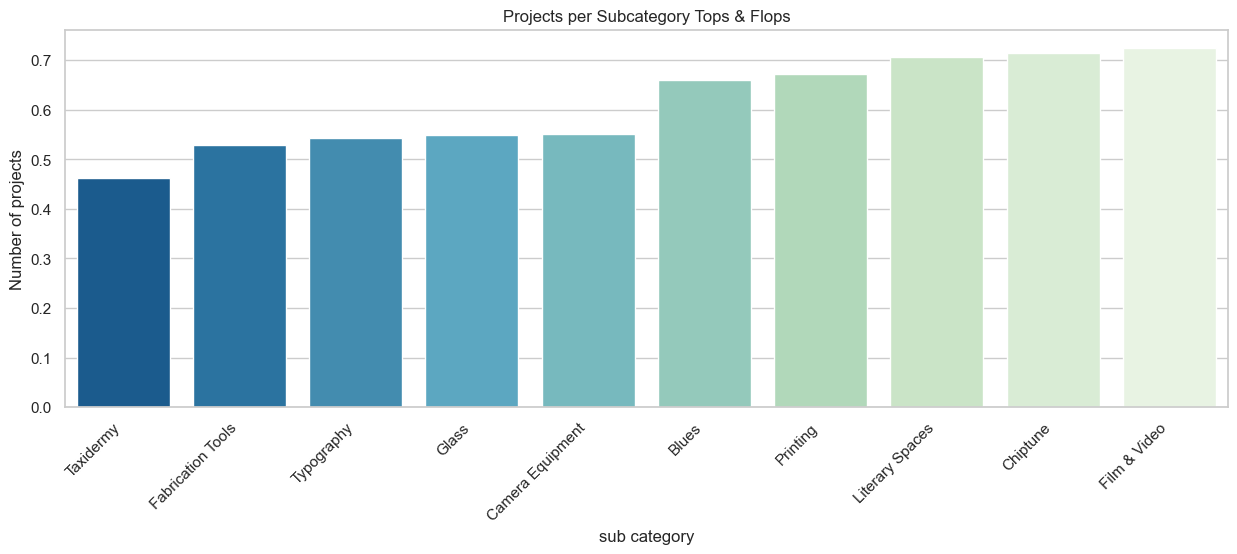

In [108]:
plt.figure(dpi=100)

chart=sns.barplot(data=sub_out, x="category_name", y="percent",palette='GnBu_r')
                  
plt.title("Projects per Subcategory Tops & Flops", fontsize=12)
plt.xlabel("sub category")
plt.ylabel("Number of projects")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

### creator

In [109]:
# split column creator - not possible
# show the whole entry in a colum 
pd.set_option('display.max_colwidth', -1)
df.creator[1]

'{"id":723886115,"name":"Lisa Vollrath","slug":"lisavollrath","is_registered":null,"chosen_currency":null,"avatar":{"thumb":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=40&h=40&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=6f941b16c6c05cc5722b182874032842","small":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=eee046cfdb8810ddc961450cdf114f6d","medium":"https://ksr-ugc.imgix.net/assets/005/864/451/bcb1e27325c110287e4cade12433e161_original.jpg?ixlib=rb-1.1.0&w=160&h=160&fit=crop&v=1525353537&auto=format&frame=1&q=92&s=eee046cfdb8810ddc961450cdf114f6d"},"urls":{"web":{"user":"https://www.kickstarter.com/profile/lisavollrath"},"api":{"user":"https://api.kickstarter.com/v1/users/723886115?signature=1552621781.028aa6bdab59abedd2a1eb192d77735f53c218df"}}}'

**Comment** After taking a closer look on the column creator, we decided to drop that colum. There is no usecase for the creator name. 

### location

In [110]:
# split column location 
df['location'] = df['location'].astype('str')
df_loc = df['location'].apply(lambda x: pd.Series(x.split(','))) 
df_loc.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,"{""id"":2400549","""name"":""Euless""","""slug"":""euless-tx""","""short_name"":""Euless","TX""","""displayable_name"":""Euless","TX""","""localized_name"":""Euless""","""country"":""US""","""state"":""TX""","""type"":""Town""","""is_root"":false","""urls"":{""web"":{""discover"":""https://www.kickstarter.com/discover/places/euless-tx""","""location"":""https://www.kickstarter.com/locations/euless-tx""}","""api"":{""nearby_projects"":""https://api.kickstarter.com/v1/discover?signature=1552595201.21559901337a1cbb442882fc58ce69fbdd8eec26&woe_id=2400549""}}}",NaN,NaN
2,"{""id"":2423474","""name"":""Hollywood""","""slug"":""hollywood-los-angeles-ca""","""short_name"":""Hollywood","CA""","""displayable_name"":""Hollywood",Los Angeles,"CA""","""localized_name"":""Hollywood""","""country"":""US""","""state"":""CA""","""type"":""Suburb""","""is_root"":false","""urls"":{""web"":{""discover"":""https://www.kickstarter.com/discover/places/hollywood-los-angeles-ca""","""location"":""https://www.kickstarter.com/locations/hollywood-los-angeles-ca""}","""api"":{""nearby_projects"":""https://api.kickstarter.com/v1/discover?signature=1552595063.1a149497bdda0fc35fb0f9107dcfe43a1fc18029&woe_id=2423474""}}}",NaN


In [111]:
# drop irrelevant cols
df_loc.drop([0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16], axis=1, inplace=True)

In [112]:
# split strings in 1 by : and create new cols
df_loc["name"], df_loc["state"] = df_loc[1].str.split(':', 1).str

In [113]:
# split strings in 8 by : and create new cols
df_loc["c"], df_loc["country"] = df_loc[8].str.split(':', 1).str

In [114]:
# drop irrelevant columns
df_loc.drop([1, 8, "name", "c"], axis=1, inplace=True)

In [115]:
# replace / remove quotes 
for i, col in enumerate(df_loc.columns):
    df_loc.iloc[:, i] = df_loc.iloc[:, i].str.replace('"', '')

In [116]:
# rename column 4 and create a new feature city
df_loc.rename(columns={"state": "city", 4: "state"}, inplace=True)

In [117]:
df_loc.head()

,state,city,country
1,TX,Euless,US
2,CA,Hollywood,Hollywood
3,Lithuania,Kaunas,LT
4,MI,Traverse City,US
5,MD,Annapolis,US


In [118]:
# Counting the number of unique locations
df_loc.city.nunique()

12342

**Comment** It's quiet interesting to take a closer look at the state and city. But as the data should to be cleaned, we decided to keep the new feature "city" in mind for future work. 

### photo

In [119]:
# split column photo
# df.photo[1]
df["photo"].astype('str')
df_pho = df['photo'].apply(lambda x: pd.Series(x.split(','))) 
df_pho.head(2)

,0,1,2,3,4,5,6,7,8
1,"{""key"":""assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg""","""full"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=90bdce91db36494610fd98402dfe9712""","""ed"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=352&h=198&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=3484e37f5556e7089af3873bbb852acc""","""med"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=272&h=153&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=b4e6fc952f50f318de29780405e6c570""","""little"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=208&h=117&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=3bc1f2c21cba6e531e9de54219841e5a""","""small"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=160&h=90&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=5e1da79626334c50dfad9f1a9915d713""","""thumb"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=48&h=27&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=2bf9958d2f4e3317740f73722d97b33b""","""1024x576"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1024&h=576&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=3c6dcf2e686304d695530f31ddda0446""","""1536x864"":""https://ksr-ugc.imgix.net/assets/017/766/989/dd9f18c773a8546d996293a20e2c422b_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1502053663&auto=format&frame=1&q=92&s=303e28e5899b51063369a2c0370872c6""}"
2,"{""key"":""assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg""","""full"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=560&h=315&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=649af6e315ebf122fc8659e35257d272""","""ed"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=352&h=198&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=4cd2dc35b5cba86d5834addbebc39612""","""med"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=272&h=153&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=c812ab119150b5822adc9e8be7254ee3""","""little"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=208&h=117&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=2ecf43506a3b12325a77d2149ee77a76""","""small"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=160&h=90&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=b9a1d6f668d9817ea44c94c10852c329""","""thumb"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=48&h=27&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=a2e9a529f4e5d2494ef986a11cc4a87d""","""1024x576"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1024&h=576&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=7e6024b738dd4dc07cca66e2673f3805""","""1536x864"":""https://ksr-ugc.imgix.net/assets/011/433/681/489fd66f7861fefd8c82adbe57c1a4ac_original.jpg?ixlib=rb-1.1.0&crop=faces&w=1552&h=873&fit=crop&v=1463682668&auto=format&frame=1&q=92&s=41ad8493bd7e5ddc97bb66f6b5c78b7f""}"


In [120]:
# split strings and create a new feature medium
df_pho["key"], df_pho["medium"] = df_pho[0].str.split('.', 1).str

In [121]:
# drop irrelevant cols
df_pho.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, "key"], axis=1, inplace=True)

In [122]:
# replace / remove quotes 
for i, col in enumerate(df_pho.columns):
    df_pho.iloc[:, i] = df_pho.iloc[:, i].str.replace('"', '')

In [123]:
# all lower case to sum different typos up
df_pho['medium'] = [str(i).lower() for i in df_pho['medium']] 

# check how many each type 
df_pho.medium.value_counts()

jpg      143979
png      40907 
jpeg     5733  
gif      969   
tif      423   
bmp      373   
tiff     123   
         108   
jpe      29    
psd      4     
mov      2     
htm      2     
exe      1     
db       1     
rtfd     1     
lrcat    1     
nan      1     
wdp      1     
m4v      1     
wmv      1     
odg      1     
stx      1     
heic     1     
pptx     1     
Name: medium, dtype: int64

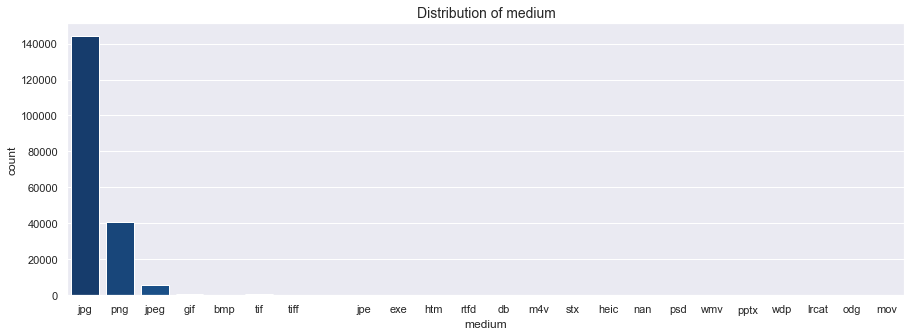

In [124]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x="medium", data=df_pho, palette="Blues_r")
plt.title('Distribution of medium', fontsize=14);

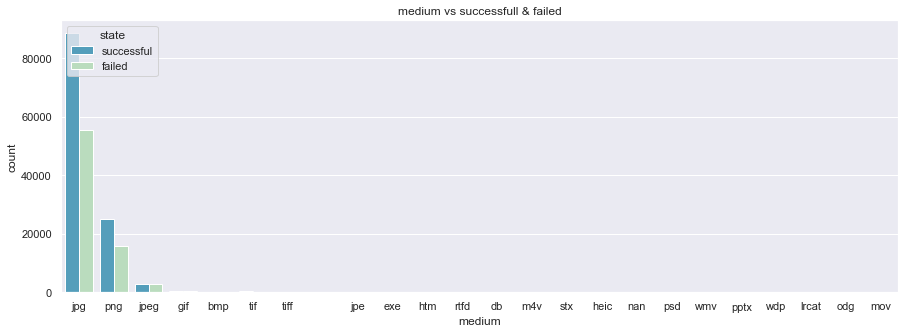

In [125]:
sns.countplot(x=df_pho.medium, data=df, hue='state', palette="GnBu_r")
plt.title('medium vs successfull & failed')
plt.xlabel("medium")
plt.ylabel("count");

**Comment** It's quiet interesting to take a closer look at the medium. But as the data "medium" des have many different expressions, we decided to keep the new feature "medium" in mind for future work.

### profile

In [126]:
# split column profile - drop
# df.profile[1]
df["profile"].astype('str')
df_prof = df['profile'].apply(lambda x: pd.Series(x.split(','))) 
df_prof.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
1,"{""id"":3094785","""project_id"":3094785","""state"":""active""","""state_changed_at"":1505402530","""name"":""The Ofrenda Oracle Deck""","""blurb"":""A colorful Dia de los Muertos themed oracle deck & guidebook for all you tarot lovers","from mixed media artist Lisa Vollrath.""","""background_color"":""""","""text_color"":""000000""","""link_background_color"":""fd7a00""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"{""id"":359847","""project_id"":359847","""state"":""inactive""","""state_changed_at"":1425915819","""name"":null","""blurb"":null","""background_color"":null","""text_color"":null","""link_background_color"":null","""link_text_color"":null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
# split strings in 0 by . and create new cols
df_prof["key"], df_prof["activity"] = df_prof[2].str.split(':', 1).str

In [128]:
df_prof.head(2)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,key,activity
1,"{""id"":3094785","""project_id"":3094785","""state"":""active""","""state_changed_at"":1505402530","""name"":""The Ofrenda Oracle Deck""","""blurb"":""A colorful Dia de los Muertos themed oracle deck & guidebook for all you tarot lovers","from mixed media artist Lisa Vollrath.""","""background_color"":""""","""text_color"":""000000""","""link_background_color"":""fd7a00""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""state""","""active"""
2,"{""id"":359847","""project_id"":359847","""state"":""inactive""","""state_changed_at"":1425915819","""name"":null","""blurb"":null","""background_color"":null","""text_color"":null","""link_background_color"":null","""link_text_color"":null",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""state""","""inactive"""


In [129]:
# drop irrelevant cols
df_prof.drop(df_prof.iloc[:, 0:33], axis=1, inplace=True)

In [130]:
# replace / remove quotes 
for i, col in enumerate(df_prof.columns):
    df_prof.iloc[:, i] = df_prof.iloc[:, i].str.replace('"', '')

In [131]:
# check how many each type 
df_prof.activity.value_counts()

inactive    155264
active      37400 
Name: activity, dtype: int64

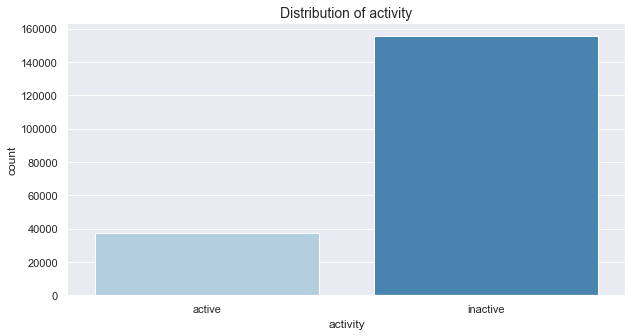

In [132]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x="activity", data=df_prof, palette="Blues")
plt.title('Distribution of activity', fontsize=14);

In [133]:
# join to df 
df['activity'] = df_prof.activity

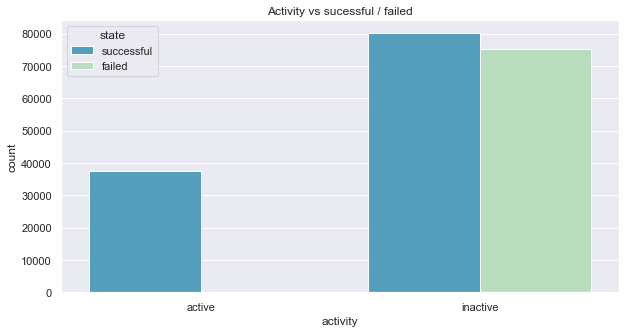

In [134]:
sns.countplot(x='activity',data=df, hue='state', palette="GnBu_r")
plt.title('Activity vs sucessful / failed')
plt.xlabel("activity")
plt.ylabel("count");

**Comment** We created a new feature "active" and "inactive" but in the end there is no usecase for our project goal. So we won't concider it for our future model. 

### blurb

In [135]:
# rename column blurb, obviously it's like a projectinfo text
df.rename(columns={"blurb": "projectinfo"}, inplace=True)

In [136]:
# get the length of the string of projectinfo column and created a new feature pi_length
df.projectinfo = df.projectinfo.astype(str)
df['pi_length'] = df['projectinfo'].apply(len)

In [137]:
print("The longest projectinfo text are:")
print(df.pi_length.nlargest(3))

The longest projectinfo text are:
201546    196
89439     151
4108      150
Name: pi_length, dtype: int64


In [138]:
print("The shortest projectinfo text are:")
print(df.pi_length.nsmallest(3))

The shortest projectinfo text are:
14242    1
14559    1
24912    1
Name: pi_length, dtype: int64


In [139]:
df.pi_length.describe()

count    192664.000000
mean     112.430631   
std      26.575918    
min      1.000000     
25%      101.000000   
50%      124.000000   
75%      132.000000   
max      196.000000   
Name: pi_length, dtype: float64

In [140]:
# make bins
bins = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
df['pi_length_bins'] = pd.cut(df['pi_length'], bins)

In [141]:
df.pi_length_bins.value_counts()

(120, 140]    106455
(100, 120]    38130 
(80, 100]     20766 
(60, 80]      13405 
(40, 60]      8538  
(20, 40]      4062  
(0, 20]       690   
(140, 160]    617   
(180, 200]    1     
(160, 180]    0     
Name: pi_length_bins, dtype: int64

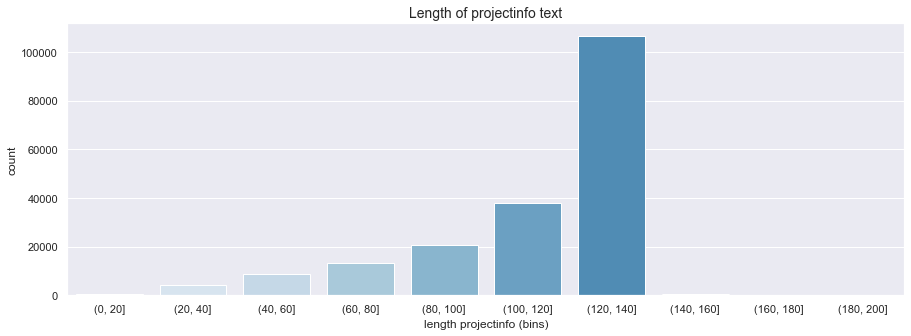

In [142]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x= df.pi_length_bins, data=df, palette="Blues")
plt.title('Length of projectinfo text', fontsize=14)
plt.xlabel("length projectinfo (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

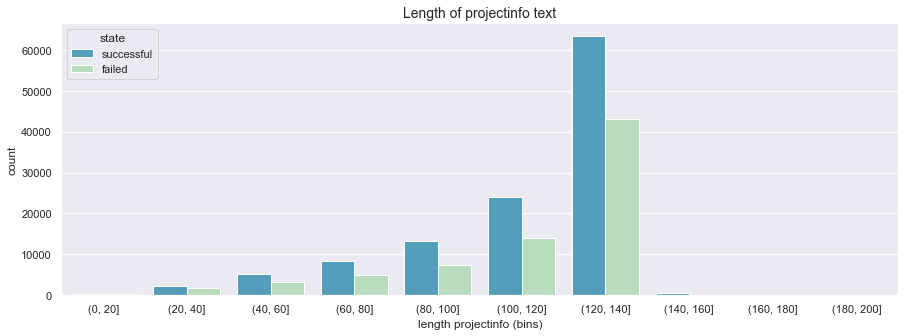

In [143]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x=df.pi_length_bins,data=df, hue='state', palette="GnBu_r")
plt.title('Length of projectinfo text', fontsize=14)
plt.xlabel("length projectinfo (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

**Comment**
The length of the projectinfo text seems to be importand. Between 118 and 138 letters/symbols seem to be the best. We will add this to our future work. 

### name

In [144]:
# get the length of the string of name column and created a new feature name_length
df['name_length'] = df['name'].apply(len)

In [145]:
print("The longest names are:")
print(df.name_length.nlargest(5))

The longest names are:
32403    85
49376    85
52496    85
65385    85
70008    85
Name: name_length, dtype: int64


In [146]:
print("The shortest names are:")
print(df.name_length.nsmallest(5))

The shortest names are:
14559     1
32732     1
183600    1
6770      2
27513     2
Name: name_length, dtype: int64


In [147]:
# extracting least 5 
least5 = df.nsmallest(5, "name_length") 
least5[["name", "name_length", "state"]]

,name,name_length,state
14559,x,1,failed
32732,I,1,successful
183600,C,1,failed
6770,X2,2,successful
27513,B1,2,failed


In [148]:
# extracting longest 5 
longest5 = df.nlargest(5, "name_length") 
longest5[["name", "name_length", "state"]]

,name,name_length,state
32403,VIOLET ISLE's 1st CD is near completion! Your pre-order pledge ensure's it's release!,85,successful
49376,Peace Partners: 55 International musicians made the music; now it's time to make a CD,85,failed
52496,EXP. Video Game Art & Culture magazine: mass production & second book: The Controller,85,successful
65385,SOUTHBOUND FORREST - Hiking and Writing the Appalachian Trail in an Unusual Direction,85,successful
70008,Generate Energy For Barn Razing & Redevelopment At The Imagination Station In Detroit,85,successful


In [149]:
# make bins 
df.name_length = pd.cut(df['name_length'], bins = 10)

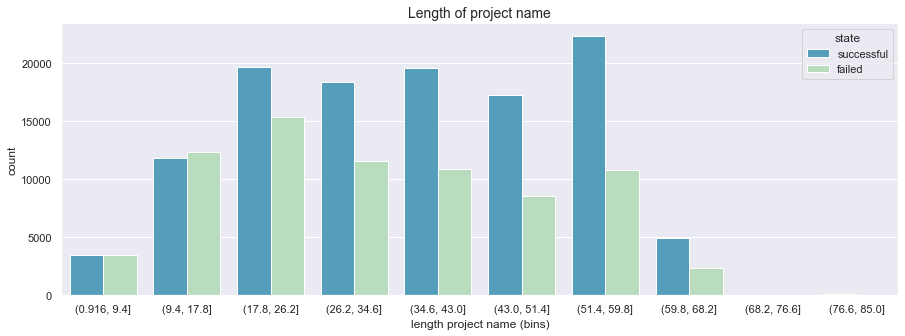

In [150]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x='name_length',data=df, hue='state', palette="GnBu_r");
plt.title('Length of project name', fontsize=14)
plt.xlabel("length project name (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

**Comment**
We've created a new feature "name_length" The shortes one does only have a length of 1 up to 96 letters/symbols. 
At this stage we decided to keep the name_length for our future work. Additionally we keep in mind to check if there is a difference between capitals only / capitals in name

### staff pick

In [151]:
df.staff_pick.value_counts()

False    166671
True     25993 
Name: staff_pick, dtype: int64

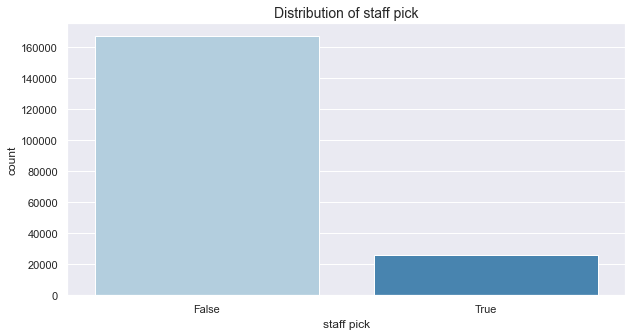

In [152]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x="staff_pick", data=df, palette="Blues")
plt.title('Distribution of staff pick', fontsize=14)
plt.xlabel("staff pick", fontsize=12)
plt.ylabel("count", fontsize=12);

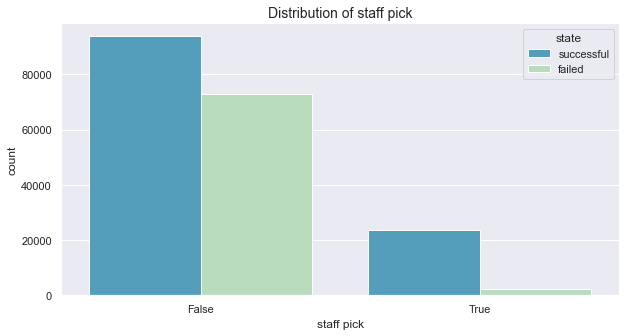

In [153]:
sns.countplot(x='staff_pick',data=df, hue='state', palette="GnBu_r")
plt.title('Distribution of staff pick', fontsize=14)
plt.xlabel("staff pick", fontsize=12)
plt.ylabel("count", fontsize=12);

**Comment** We decided to keep this feature because it's only true / fales and might be relevant if you do have a short video or not. Interesting that it seems like if most of the projects don't have any videos?

### disable communication

In [154]:
# Check disable communication
df.disable_communication.value_counts()

False    192664
Name: disable_communication, dtype: int64

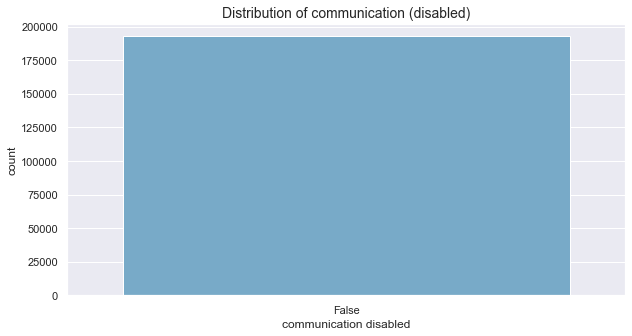

In [155]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x="disable_communication", data=df, palette="Blues")
plt.title('Distribution of communication (disabled)', fontsize=14)
plt.xlabel("communication disabled", fontsize=12)
plt.ylabel("count", fontsize=12);

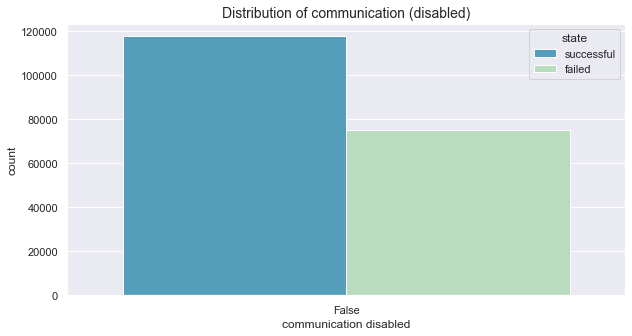

In [156]:
sns.countplot(x='disable_communication',data=df, hue='state', palette="GnBu_r")
plt.title('Distribution of communication (disabled)', fontsize=14)
plt.xlabel("communication disabled", fontsize=12)
plt.ylabel("count", fontsize=12);

In [157]:
# impact of the feature disable_communication of a project
df_comm=df.groupby(["disable_communication","state"]).count()
df_comm

backers_count  projectinfo  category  \
disable_communication state                                              
False                 failed      75199          75199        75199      
                      successful  117465         117465       117465     

                                  converted_pledged_amount  country  \
disable_communication state                                           
False                 failed      75199                     75199     
                      successful  117465                    117465    

                                  created_at  creator  currency  \
disable_communication state                                       
False                 failed      75199       75199    75199      
                      successful  117465      117465   117465     

                                  currency_symbol  currency_trailing_code  \
disable_communication state                                                 
False                 failed      75199            75199                    
                      successful  117465           117465                   

                                  ...  pd_bins  goal_usd  goal_usd_log  \
disable_communication state       ...                                    
False                 failed      ...  75199    75199     75199          
                      successful  ...  117465   117465    117465         

                                  category_name  maincategory  \
disable_communication state                                     
False                 failed      69135          75199          
                      successful  108251         117465         

                                  maincategory_name  activity  pi_length  \
disable_communication state                                                
False                 failed      75199              75199     75199       
                      successful  117465             117465    117465      

                                  pi_length_bins  name_length  
disable_communication state                                    
False                 failed      75199           75199        
                      successful  117465          117465       

[2 rows x 66 columns]

**Comment** We decided to drop the feature "disable communication" as there are only fales values. So there is no added value to our project. 

### backers count

In [158]:
df.backers_count.value_counts()

0        15009
1        13521
2        9185 
3        6229 
4        4515 
5        3657 
6        3014 
7        2638 
8        2399 
9        2180 
10       2148 
11       2044 
12       1925 
13       1874 
14       1867 
15       1789 
18       1712 
16       1708 
17       1697 
19       1638 
20       1614 
21       1573 
22       1532 
23       1486 
24       1437 
26       1407 
25       1391 
28       1384 
30       1353 
27       1336 
         ...  
5935     1    
1965     1    
8110     1    
3169     1    
2095     1    
7139     1    
8548     1    
2145     1    
2860     1    
8873     1    
5088     1    
2016     1    
2787     1    
4905     1    
2531     1    
5033     1    
4448     1    
5417     1    
1889     1    
4010     1    
3424     1    
19304    1    
2784     1    
3373     1    
1580     1    
4451     1    
4013     1    
2220     1    
4271     1    
3966     1    
Name: backers_count, Length: 3206, dtype: int64

In [159]:
df['backers_count'].describe()

count    192664.000000
mean     152.563463   
std      898.347455   
min      0.000000     
25%      4.000000     
50%      30.000000    
75%      94.250000    
max      105857.000000
Name: backers_count, dtype: float64

In [160]:
# drop all projects with backers_count>50000
df.query('backers_count>50000').backers_count.count()

8

In [161]:
df.query('backers_count>1000').backers_count.count()

4786

In [162]:
df_b=df.query('backers_count<1000')

In [163]:
# make bins 
#df.backers_count = pd.cut(df['backers_count'], bins = 5)

In [164]:
# plot 
#sns.set(rc={'figure.figsize':(15,5)})
#sns.countplot(x='backers_count',data=df, hue='state', palette="GnBu_r")
#plt.title('Backers count', fontsize=14)
#plt.xlabel("Backers", fontsize=12)
#plt.ylabel("count", fontsize=12);

In [165]:
df_backers=df_b.groupby(["backers_count","state"])['state'].count()
                                                    
df_backers

backers_count  state     
0              failed        15009
1              failed        13254
               successful    267  
2              failed        8892 
               successful    293  
3              failed        5794 
               successful    435  
4              failed        4075 
               successful    440  
5              failed        3102 
               successful    555  
6              failed        2334 
               successful    680  
7              failed        1973 
               successful    665  
8              failed        1589 
               successful    810  
9              failed        1355 
               successful    825  
10             failed        1233 
               successful    915  
11             failed        1036 
               successful    1008 
12             failed        908  
               successful    1017 
13             failed        819  
               successful    1055 
14             failed        

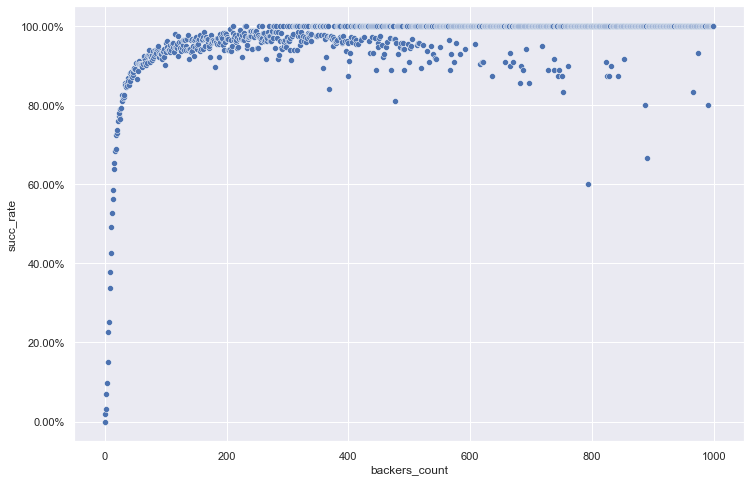

In [166]:
df_backers=df_backers.unstack()
df_backers=df_backers.fillna(0)
df_backers


df_backers["succ_rate"]=df_backers["successful"]/(df_backers["successful"]+df_backers["failed"])
plot=df_backers['succ_rate'][0:500]
df_backersdf=pd.DataFrame(df_backers[0:501])

f,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_backers["succ_rate"])
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'. format(x) for x in vals])


plt.show()

#### Zerofollowers and subcategories

In [29]:
# Zero followers
df[df['backers_count'] == 0].groupby('category_name').count()['id'] 
zero_followers = df[df['backers_count'] == 0].groupby('category_name').count()['id']  / df['category_name'].value_counts()


In [30]:
zero_followers.describe()

count    129.000000
mean       0.107455
std        0.063035
min        0.010553
25%        0.056000
50%        0.096875
75%        0.146269
max        0.292553
dtype: float64

In [31]:
# the subcategories with the top 5 / flop 5 percentag of zerofollowers
zero_followers_top5=zero_followers.head(5)
zero_followers_flop5=zero_followers.tail(5)
zero_out=pd.concat([zero_followers_top5, zero_followers_flop5], axis=0)
zero_out=zero_out.sort_values()

NameError: name 'f' is not defined

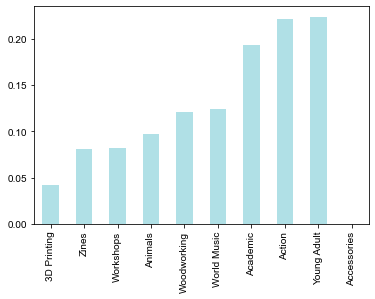

In [32]:
zero_out.plot(kind='bar',color="powderblue")
sns.set_style("whitegrid")

f.autofmt_xdate()
ax.set_title("Percentage of Projects with Zero Backers Top & Flops")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

#### Plotting Backers quote against Subcategory

In [33]:
categories=df.groupby(['category_name'])['id'].count().reset_index(name='count')
categories=categories.sort_values('category_name')
categories

,category_name,count
0,3D Printing,758
1,Academic,952
2,Accessories,3330
3,Action,754
4,Animals,320
5,Animation,2458
6,Anthologies,1243
7,Apparel,2766
8,Apps,2422
9,Architecture,759


In [34]:
backers = df.groupby('category_name')['category_name','backers_count'].sum().reset_index()

backers=backers.sort_values('category_name')
backers=backers['backers_count']
#backers

In [36]:
backers_agg=pd.concat([backers,categories],axis=1)
backers_agg

,backers_count,category_name,count
0,207834,3D Printing,758
1,45555,Academic,952
2,441526,Accessories,3330
3,47208,Action,754
4,20970,Animals,320
5,376711,Animation,2458
6,298138,Anthologies,1243
7,555849,Apparel,2766
8,152626,Apps,2422
9,43108,Architecture,759


In [37]:
backers_agg['backers_quote']=backers_agg['backers_count']/backers_agg['count']
backers_agg=backers_agg.sort_values('backers_quote')
backers_flop=backers_agg.head(5)
backers_top=backers_agg.tail(5)

In [38]:
backers_agg.describe()

,backers_count,count,backers_quote
count,1.590000e+02,159.000000,159.000000
mean,1.848647e+05,1211.723270,130.384383
std,4.155095e+05,997.037383,165.497347
min,8.670000e+02,15.000000,12.710280
25%,2.433150e+04,340.500000,41.880610
50%,6.455600e+04,846.000000,65.563960
75%,1.746405e+05,2178.000000,146.271409
max,3.233930e+06,4322.000000,1328.102669


In [39]:
backers_out=pd.concat([backers_top, backers_flop], axis=0)
backers_out=backers_out.sort_values('backers_quote',ascending=False)

In [40]:
backers_number=backers_agg.sort_values('backers_quote')

<function matplotlib.pyplot.show(close=None, block=None)>

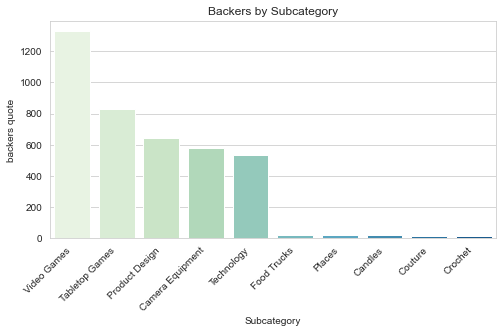

In [41]:
# Breaking down backers by subcategory


f, ax = plt.subplots(figsize=(8, 4))

chart=sns.barplot(x="category_name", y="backers_quote", data=backers_out, palette="GnBu")
plt.title("Backers by Subcategory")
plt.ylabel("backers quote")
plt.xlabel("Subcategory")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show

### currency_trailing_code

In [42]:
# trailing code depends on currency, false if usd is weak
df5=df.groupby(['currency_trailing_code','currency']).sum()
df5

backers_count  converted_pledged_amount  \
currency_trailing_code currency                                            
False                  CHF               76916                  12558512   
                       EUR             1792491                 172259990   
                       GBP             2681748                 203636843   
                       JPY               59840                   6803735   
True                   AUD              493202                  36137509   
                       CAD             1136723                  76766291   
                       DKK              116612                  10193528   
                       HKD              261207                  27366917   
                       MXN               78138                   4508595   
                       NOK               35871                   3920714   
                       NZD               84827                   6830612   
                       SEK              197842                  17804256   
                       SGD               91519                   7769311   
                       USD            22286551                2015501747   

                                 disable_communication        fx_rate  \
currency_trailing_code currency                                         
False                  CHF                         0.0     593.895760   
                       EUR                         0.0   14026.365509   
                       GBP                         0.0   28031.720295   
                       JPY                         0.0       2.961118   
True                   AUD                         0.0    3096.335243   
                       CAD                         0.0    6675.242387   
                       DKK                         0.0     127.177732   
                       HKD                         0.0     121.447110   
                       MXN                         0.0     105.482536   
                       NOK                         0.0      52.755182   
                       NZD                         0.0     580.331128   
                       SEK                         0.0     137.385954   
                       SGD                         0.0     460.491395   
                       USD                         0.0  137793.377715   

                                         goal               id  is_starrable  \
currency_trailing_code currency                                                
False                  CHF       2.305161e+08     613983366777           0.0   
                       EUR       6.127525e+08   13283578199860           0.0   
                       GBP       3.825212e+08   22625808847636           0.0   
                       JPY       6.079574e+08     382949799441           0.0   
True                   AUD       3.427003e+08    4717504282867           0.0   
                       CAD       3.545000e+08    9576470092240           0.0   
                       DKK       9.249528e+07     891139235979           0.0   
                       HKD       1.138727e+08    1017761703042           0.0   
                       MXN       4.440229e+08    2183489866663           0.0   
                       NOK       6.424761e+07     499239082568           0.0   
                       NZD       1.448193e+07     884821596323           0.0   
                       SEK       3.582146e+08    1403881430837           0.0   
                       SGD       1.090332e+07     667619290873           0.0   
                       USD       5.096200e+09  147925271490682           0.0   

                                      pledged  spotlight  staff_pick  ...  \
currency_trailing_code currency                                       ...   
False                  CHF       1.238835e+07      292.0        50.0  ...   
                       EUR       1.504829e+08     5927.0      1380.0  ...   
                       GBP       1.461486e+08    13883.0  

In [43]:
# impact of the trailing code to the success of a project
df_trailing=df.groupby(["currency_trailing_code","state"]).count()
df_trailing

backers_count  blurb  category  \
currency_trailing_code state                                        
False                  failed              14216  14215     14216   
                       successful          20345  20345     20345   
True                   failed              60983  60982     60983   
                       successful          97120  97120     97120   

                                   converted_pledged_amount  country  \
currency_trailing_code state                                           
False                  failed                         14216    14216   
                       successful                     20345    20345   
True                   failed                         60983    60983   
                       successful                     97120    97120   

                                   created_at  creator  currency  \
currency_trailing_code state                                       
False                  failed           14216    14216     14216   
                       successful       20345    20345     20345   
True                   failed           60983    60983     60983   
                       successful       97120    97120     97120   

                                   currency_symbol  current_currency  ...  \
currency_trailing_code state                                          ...   
False                  failed                14216             14216  ...   
                       successful            20345             20345  ...   
True                   failed                60983             60983  ...   
                       successful            97120             97120  ...   

                                   time_created  year_state_changed  \
currency_trailing_code state                                          
False                  failed             14216               14216   
                       successful         20345               20345   
True                   failed             60983               60983   
                       successful         97120               97120   

                                   month_state_changed  day_state_changed  \
currency_trailing_code state                                                
False                  failed                    14216              14216   
                       successful                20345              20345   
True                   failed                    60983              60983   
                       successful                97120              97120   

                                   time_state_changed  goal_usd  goal_usd_log  \
currency_trailing_code state                                                    
False                  failed                   14216     14216         14216   
                       successful               20345     20345         20345   
True                   failed                   60983     60983         60983   
                       successful               97120     97120         97120   

                                   category_name  maincategory  \
currency_trailing_code state                                     
False                  failed              14216         14216   
                       successful          20345         20345   
True                   failed              60983         60983   
                       successful          97120         97120   

                                   maincategory_name  
currency_trailing_code state                          
False                  failed                  14216  
                       successful              20345  
True                   failed                  60983  
                       successful              97120  

[4 rows x 57 columns]

In [44]:
#No significant change of the success rate due to the trailing code-> the feature can be dropped 
20345/(14216+20345),97120/(97120+60983)

(0.588669309337114, 0.6142830939324364)

### current currency

In [45]:
# Analysis of column current_currency, currency shown on the website -> not used for data explanation but perhaps 
# of importance when you trie to predict the data
df.groupby(['current_currency','currency'])['state'].agg(['count'])


count
current_currency currency        
CAD              AUD            1
                 CAD            2
                 EUR            8
                 GBP            8
                 HKD            1
                 NOK            1
                 SEK            1
                 USD           16
USD              AUD         4382
                 CAD         8894
                 CHF          597
                 DKK          839
                 EUR        12391
                 GBP        21227
                 HKD          952
                 JPY          330
                 MXN         2038
                 NOK          452
                 NZD          848
                 SEK         1280
                 SGD          624
                 USD       137772

### currency

In [46]:
df.currency.value_counts()

USD    137788
GBP     21235
EUR     12399
CAD      8896
AUD      4383
MXN      2038
SEK      1281
HKD       953
NZD       848
DKK       839
SGD       624
CHF       597
NOK       453
JPY       330
Name: currency, dtype: int64

In [47]:
df_eur=df.query("currency=='EUR'")

In [48]:
df_eur_new=df.query("currency=='EUR'")

In [49]:
df_eur=df_eur.groupby(["static_usd_rate","state"])['state'].count()
                                                    
df_eur

static_usd_rate  state     
1.040305         failed        5
                 successful    1
1.040363         failed        5
                 successful    2
1.041273         failed        2
                 successful    1
1.043242         failed        2
                 successful    1
1.043297         failed        3
1.043765         failed        7
1.044120         failed        3
                 successful    1
1.044880         failed        4
1.045350         failed        9
                 successful    1
1.045567         failed        5
1.046125         failed        4
                 successful    4
1.046170         failed        8
                 successful    2
1.047150         failed        4
                 successful    1
1.048950         failed        4
                 successful    4
1.049636         failed        1
1.051193         failed        5
                 successful    1
1.051851         failed        4
                 successful    2
1.051949       

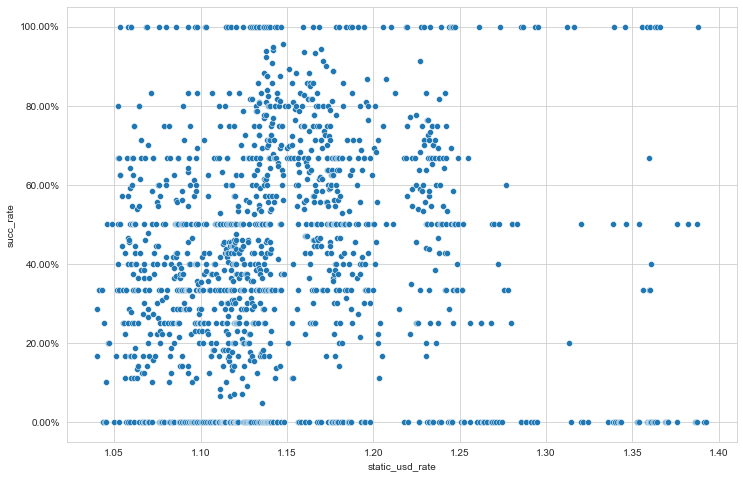

In [50]:
df_eur=df_eur.unstack()
df_eur=df_eur.fillna(0)
df_eur

df_eur["succ_rate"]=df_eur["successful"]/(df_eur["successful"]+df_eur["failed"])
plot=df_eur['succ_rate'][0:500]
df_goaldf=pd.DataFrame(df_eur[0:501])

f,ax=plt.subplots(figsize=(12,8))

sns.scatterplot(data=df_eur["succ_rate"])
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'. format(x) for x in vals])


plt.show()

### statisc_usd_rate

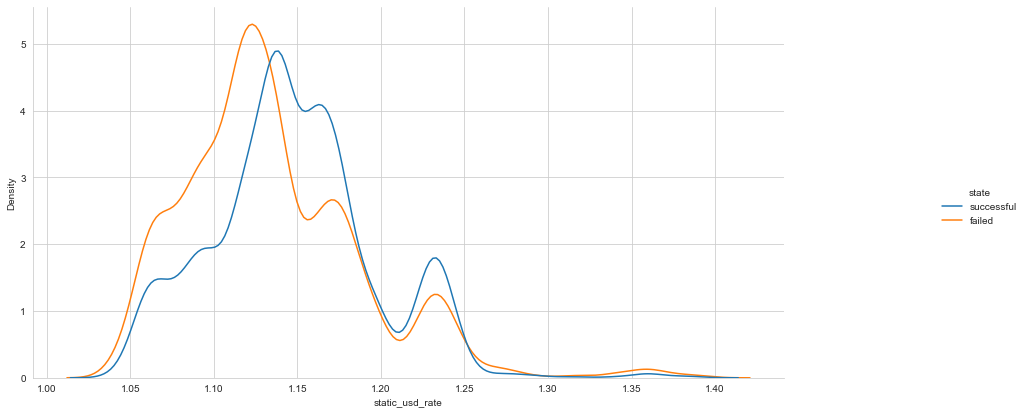

In [51]:
g=sns.displot(df_eur_new, x="static_usd_rate",hue='state', kind='kde')
g.fig.set_size_inches(15,6)

**Finding** There is no correlation between the EUR currency and the success of a project 

### usd_pledged

In [52]:
df.describe()['usd_pledged'].round(2)

count     192664.00
mean       13516.72
std        89183.97
min            0.00
25%          150.00
50%         1772.00
75%         7096.62
max      8596474.58
Name: usd_pledged, dtype: float64

In [53]:
df.usd_pledged.sort_values().tail(10)

39784     5.333793e+06
55326     5.408917e+06
43500     5.545992e+06
125652    5.702153e+06
37821     5.764229e+06
187230    6.225355e+06
7204      6.297405e+06
171919    6.297405e+06
84290     6.333296e+06
168630    8.596475e+06
Name: usd_pledged, dtype: float64

In [54]:
#check doesnt plot right
#sns.scatterplot(data=df, x="backers_count", y="usd_pledged")

In [55]:
# creating a new feature
df["usd_pledged_log"]=np.log(df.usd_pledged)

In [56]:
# creating a new feature goal_usd_log and usd_pledged_log
df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged)

In [57]:
# Analysis concerning the rates, the static_usd_rate is the historic rate which is used for computation, the fx_rate i
# is the actual rate which is the same dependent on currency
df["fehler_1"]=df.usd_pledged-df.pledged*df.fx_rate
df["fehler_2"]=df.usd_pledged-df.pledged*df.static_usd_rate

In [58]:
df_umr=df.query(
                'usd_pledged-pledged*static_usd_rate>1')
df_umr[['state','usd_pledged','pledged','fehler_1','fehler_2','goal','converted_pledged_amount','current_currency','currency','fx_rate','static_usd_rate']]                

,state,usd_pledged,pledged,fehler_1,fehler_2,goal,converted_pledged_amount,current_currency,currency,fx_rate,static_usd_rate


In [59]:
# trailing code depends on currency, false if usd is weak
df5=df.groupby(['currency_trailing_code','currency']).sum()
df5

backers_count  converted_pledged_amount  \
currency_trailing_code currency                                            
False                  CHF               76916                  12558512   
                       EUR             1792491                 172259990   
                       GBP             2681748                 203636843   
                       JPY               59840                   6803735   
True                   AUD              493202                  36137509   
                       CAD             1136723                  76766291   
                       DKK              116612                  10193528   
                       HKD              261207                  27366917   
                       MXN               78138                   4508595   
                       NOK               35871                   3920714   
                       NZD               84827                   6830612   
                       SEK              197842                  17804256   
                       SGD               91519                   7769311   
                       USD            22286551                2015501747   

                                 disable_communication        fx_rate  \
currency_trailing_code currency                                         
False                  CHF                         0.0     593.895760   
                       EUR                         0.0   14026.365509   
                       GBP                         0.0   28031.720295   
                       JPY                         0.0       2.961118   
True                   AUD                         0.0    3096.335243   
                       CAD                         0.0    6675.242387   
                       DKK                         0.0     127.177732   
                       HKD                         0.0     121.447110   
                       MXN                         0.0     105.482536   
                       NOK                         0.0      52.755182   
                       NZD                         0.0     580.331128   
                       SEK                         0.0     137.385954   
                       SGD                         0.0     460.491395   
                       USD                         0.0  137793.377715   

                                         goal               id  is_starrable  \
currency_trailing_code currency                                                
False                  CHF       2.305161e+08     613983366777           0.0   
                       EUR       6.127525e+08   13283578199860           0.0   
                       GBP       3.825212e+08   22625808847636           0.0   
                       JPY       6.079574e+08     382949799441           0.0   
True                   AUD       3.427003e+08    4717504282867           0.0   
                       CAD       3.545000e+08    9576470092240           0.0   
                       DKK       9.249528e+07     891139235979           0.0   
                       HKD       1.138727e+08    1017761703042           0.0   
                       MXN       4.440229e+08    2183489866663           0.0   
                       NOK       6.424761e+07     499239082568           0.0   
                       NZD       1.448193e+07     884821596323           0.0   
                       SEK       3.582146e+08    1403881430837           0.0   
                       SGD       1.090332e+07     667619290873           0.0   
                       USD       5.096200e+09  147925271490682           0.0   

                                      pledged  spotlight  staff_pick  ...  \
currency_trailing_code currency                                       ...   
False                  CHF       1.238835e+07      292.0        50.0  ...   
                       EUR       1.504829e+08     5927.0      1380.0  ...   
                       GBP       1.461486e+08    13883.0  

In [60]:
# impact of the trailing code to the success of a project
df_trailing=df.groupby(["currency_trailing_code","state"]).count()
df_trailing

backers_count  blurb  category  \
currency_trailing_code state                                        
False                  failed              14216  14215     14216   
                       successful          20345  20345     20345   
True                   failed              60983  60982     60983   
                       successful          97120  97120     97120   

                                   converted_pledged_amount  country  \
currency_trailing_code state                                           
False                  failed                         14216    14216   
                       successful                     20345    20345   
True                   failed                         60983    60983   
                       successful                     97120    97120   

                                   created_at  creator  currency  \
currency_trailing_code state                                       
False                  failed           14216    14216     14216   
                       successful       20345    20345     20345   
True                   failed           60983    60983     60983   
                       successful       97120    97120     97120   

                                   currency_symbol  current_currency  ...  \
currency_trailing_code state                                          ...   
False                  failed                14216             14216  ...   
                       successful            20345             20345  ...   
True                   failed                60983             60983  ...   
                       successful            97120             97120  ...   

                                   day_state_changed  time_state_changed  \
currency_trailing_code state                                               
False                  failed                  14216               14216   
                       successful              20345               20345   
True                   failed                  60983               60983   
                       successful              97120               97120   

                                   goal_usd  goal_usd_log  category_name  \
currency_trailing_code state                                               
False                  failed         14216         14216          14216   
                       successful     20345         20345          20345   
True                   failed         60983         60983          60983   
                       successful     97120         97120          97120   

                                   maincategory  maincategory_name  \
currency_trailing_code state                                         
False                  failed             14216              14216   
                       successful         20345              20345   
True                   failed             60983              60983   
                       successful         97120              97120   

                                   usd_pledged_log  fehler_1  fehler_2  
currency_trailing_code state                                            
False                  failed                14216     14216     14216  
                       successful            20345     20345     20345  
True                   failed                60983     60983     60983  
                       successful            97120     97120     97120  

[4 rows x 60 columns]

In [61]:
#No significant change of the success rate due to the trailing code-> the feature can be dropped 
20345/(14216+20345),97120/(97120+60983)

(0.588669309337114, 0.6142830939324364)

In [62]:
# Analysis of column current_currency, currency shown on the website -> not used for data explanation but perhaps 
# of importance when you trie to predict the data
df.groupby(['current_currency','currency'])['state'].agg(['count'])


count
current_currency currency        
CAD              AUD            1
                 CAD            2
                 EUR            8
                 GBP            8
                 HKD            1
                 NOK            1
                 SEK            1
                 USD           16
USD              AUD         4382
                 CAD         8894
                 CHF          597
                 DKK          839
                 EUR        12391
                 GBP        21227
                 HKD          952
                 JPY          330
                 MXN         2038
                 NOK          452
                 NZD          848
                 SEK         1280
                 SGD          624
                 USD       137772

In [63]:
# Einführung neuer features goal_usd_log und usd_pledged_log
df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged)

In [64]:
# Einführung neuer features goal_usd_log und usd_pledged_log

df["goal_usd_log"]=np.log(df.goal_usd)
df["usd_pledged_log"]=np.log(df.usd_pledged)

### source_url

In [65]:
df.source_url.shape

(192664,)

**Comment** We decided to drop the feature "source_url". There seems to be no added value to our project.

### urls

In [66]:
df.urls.head(2)

1    {"web":{"project":"https://www.kickstarter.com...
2    {"web":{"project":"https://www.kickstarter.com...
Name: urls, dtype: object

In [67]:
df.urls.shape

(192664,)

In [68]:
df.urls.nunique()

168979

In [69]:
# split column urls 
df['urls'] = df['urls'].astype('str')
df_urls = df['urls'].apply(lambda x: pd.Series(x.split(','))) 
df_urls.head(2)

,0,1
1,"{""web"":{""project"":""https://www.kickstarter.com...","""rewards"":""https://www.kickstarter.com/project..."
2,"{""web"":{""project"":""https://www.kickstarter.com...","""rewards"":""https://www.kickstarter.com/project..."


In [70]:
# drop irrelevant cols
df_urls.drop([0], axis=1, inplace=True)

# split strings in 1 by : and create new cols
df_urls["rewards"], df_urls["url"] = df_urls[1].str.split(':', 1).str

In [71]:
# drop irrelevant columns
df_urls.drop([1,"url"], axis=1, inplace=True)

# replace / remove quotes 
for i, col in enumerate(df_urls.columns):
    df_urls.iloc[:, i] = df_urls.iloc[:, i].str.replace('"', '')

In [72]:
df_urls.head(2)

,rewards
1,rewards
2,rewards


### friends

In [73]:
df.friends.value_counts()
# drop can't get any information out of it

Series([], Name: friends, dtype: int64)

### country

In [74]:
#country 
df.country.value_counts()

US    137788
GB     21235
CA      8896
AU      4383
DE      3048
FR      2377
IT      2063
MX      2038
ES      1697
NL      1649
SE      1281
HK       953
NZ       848
DK       839
SG       624
CH       597
IE       575
BE       496
NO       453
AT       439
JP       330
LU        55
Name: country, dtype: int64

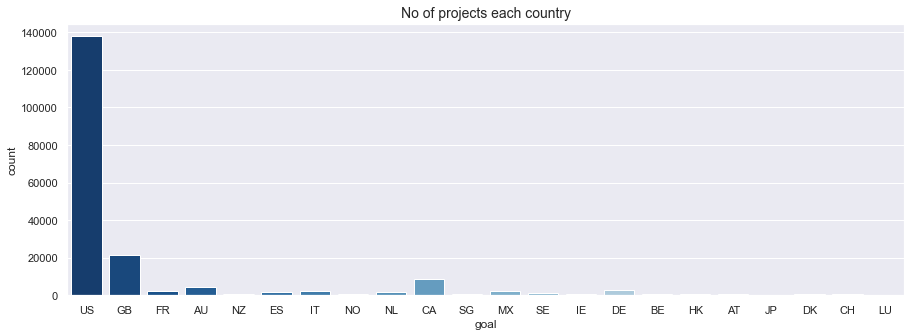

In [75]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x="country", data=df, palette="Blues_r")
plt.title('No of projects each country', fontsize=14)
plt.xlabel("goal", fontsize=12)
plt.ylabel("count", fontsize=12);

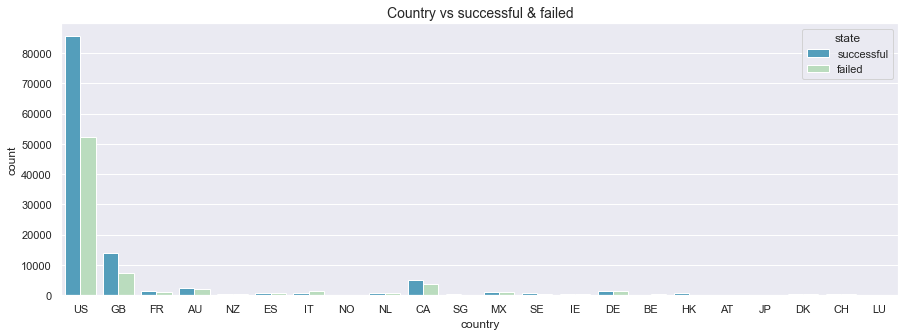

In [76]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x='country',data=df, hue='state', palette="GnBu_r")
plt.title('Country vs successful & failed', fontsize=14)
plt.xlabel("country", fontsize=12)
plt.ylabel("count", fontsize=12);

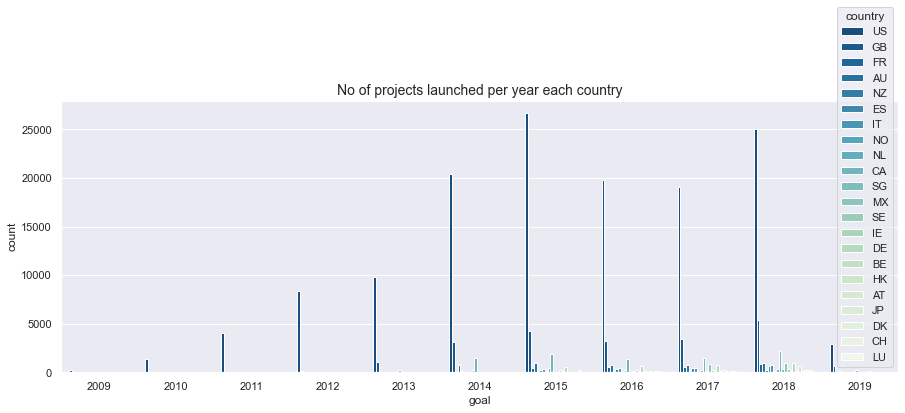

In [77]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x=df.year_launched, data=df, hue='country', palette="GnBu_r")
plt.title('No of projects launched per year each country', fontsize=14)
plt.xlabel("goal", fontsize=12)
plt.ylabel("count", fontsize=12);

#### Plotting success rate per country

In [78]:
project_country = df.groupby(['country','state'])['country'].count().reset_index(name='count')
project_country["sum_counts"] = project_country.groupby('country')['count'].transform('sum')
project_country["percent"] = project_country['count']/project_country["sum_counts"]
project_country = project_country[project_country['state'] == 'successful']
project_country=project_country.sort_values('percent',ascending=False)

In [79]:
country_top=project_country.head(10)

In [80]:
country_flop=project_country.tail(5)
country_flop

,country,state,count,sum_counts,percent
15,ES,successful,819,1697,0.482616
5,BE,successful,228,496,0.459677
1,AT,successful,201,439,0.457859
33,NL,successful,750,1649,0.454821
25,IT,successful,739,2063,0.358216


In [81]:
country_out=pd.concat([country_top, country_flop], axis=0)

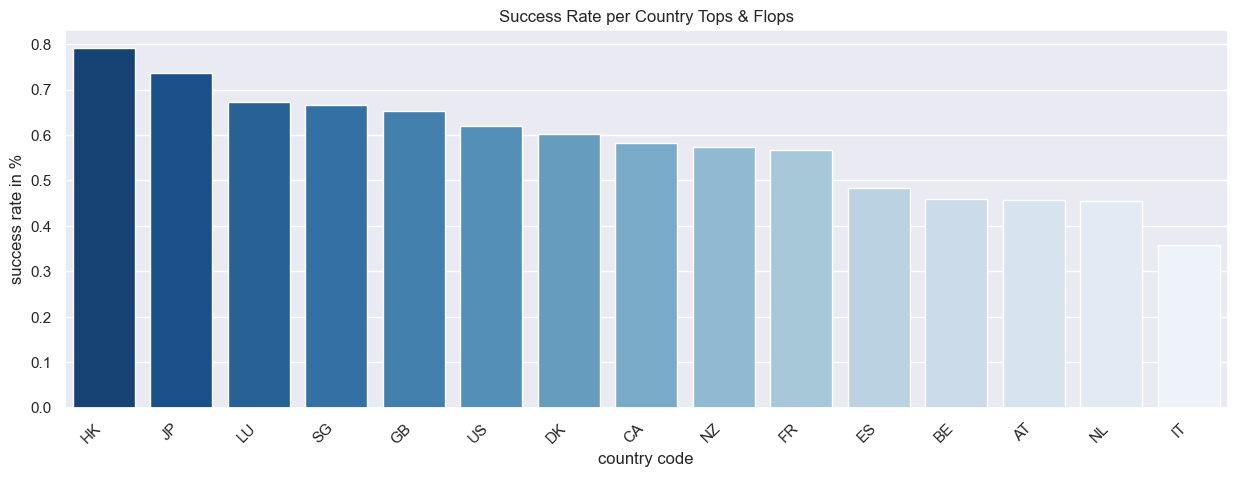

In [82]:

plt.figure(dpi=100)

chart=sns.barplot(data=country_out, x="country", y="percent",palette='Blues_r')
plt.title("Success Rate per Country Tops & Flops", fontsize=12)
plt.xlabel("country code")
plt.ylabel("success rate in %")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [83]:
# Def. dataframe for non US projects

df_non_us=df.query("country!='US'")
df_non_us=df_non_us.groupby(['maincategory_name','state'])['name'].count().reset_index(name='count_2')
df_non_us=df_non_us.sort_values('count_2',ascending=False).set_index('maincategory_name')

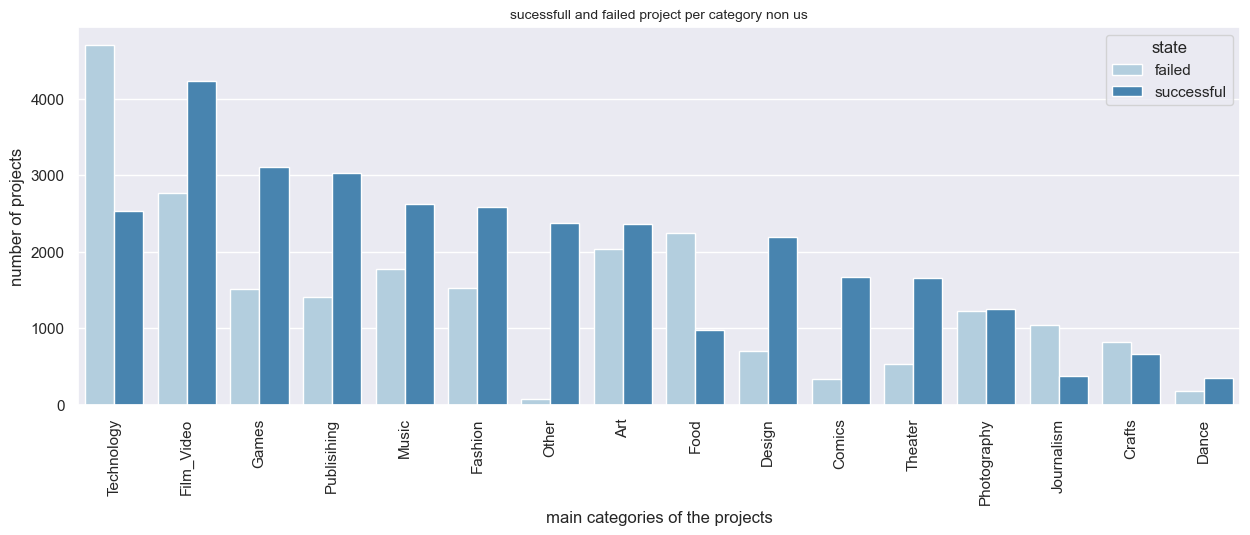

In [84]:
plt.figure(dpi=100)

sns.barplot(x=df_non_us.index,y=df_non_us['count_2'],hue= df_non_us['state'],palette="Blues")
plt.xticks(rotation=90)
plt.title("sucessfull and failed project per category non us", fontsize=10)
plt.xlabel("main categories of the projects")
plt.ylabel("number of projects")
plt.show()

#sns.barplot(x=df_us.index,y=df_us['count_1'],hue= df_us['state'],palette="pastel")
#plt.xticks(rotation=90)

#plt.title("sucessfull and failed project per category us", fontsize=10)
#plt.xlabel("main categories of the projects")
#plt.ylabel("number of projects")
#plt.show()

#### Plotting Non US pledged versus goal

In [85]:
# Goal und Pledged US for sucessful and failed projects in non us
df_non_us_succ=df.query('country!="US" and state=="successful"')

<function matplotlib.pyplot.show(close=None, block=None)>

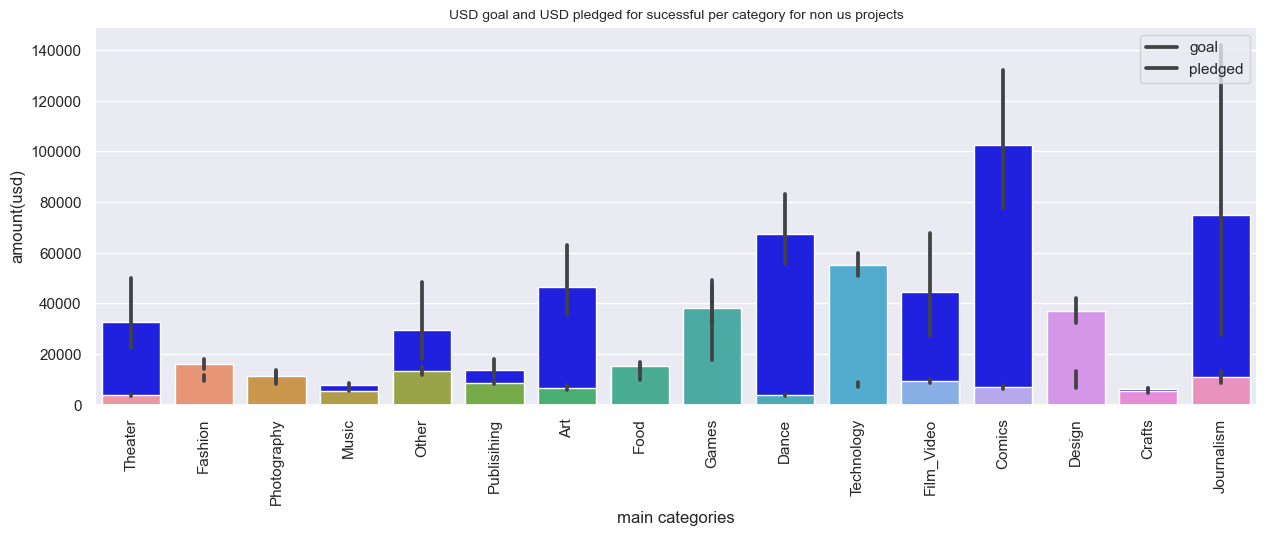

In [86]:
plt.figure(dpi=100)
sns.barplot(data=df,x=df.maincategory_name,y=df.goal_usd,color="blue")
sns.barplot(data=df_non_us_succ,x=df_non_us_succ.maincategory_name,y=df_non_us_succ.usd_pledged)
plt.title("USD goal and USD pledged for sucessful per category for non us projects",fontsize=10)
plt.xlabel("main categories")
plt.ylabel("amount(usd)")
plt.xticks(rotation=90)
plt.legend(["goal","pledged"],loc="upper right")
plt.show


###  slug 

In [87]:
# get the length of the slug column and created a new feature slug_length
df['slug_length'] = df['slug'].apply(len)

In [88]:
print("The longest slugs are:")
print(df.slug_length.nlargest(5))

The longest slugs are:
147916    121
2794       53
8914       53
18783      53
24576      53
Name: slug_length, dtype: int64


In [89]:
print("The shortest slugs are:")
print(df.slug_length.nsmallest(5))

The shortest slugs are:
146209    1
6770      2
42356     2
55715     2
55853     2
Name: slug_length, dtype: int64


In [90]:
# extracting least 5 
least5 = df.nsmallest(5, "slug_length") 
least5[["slug", "slug_length", "state"]]

,slug,slug_length,state
146209,r,1,successful
6770,x2,2,successful
42356,om,2,successful
55715,pm,2,successful
55853,us,2,successful


In [91]:
# extracting longest 5 
longest5 = df.nlargest(5, "slug_length") 
longest5[["slug", "slug_length", "state"]]

,slug,slug_length,state
147916,we-operate-best-together-a-project-exploring-g...,121,successful
2794,david-walsh-bowlmaker-fine-wooden-bowls-ltd-ed...,53,successful
8914,community-mosaic-mural-project-with-youth-in-n...,53,successful
18783,david-walsh-bowlmaker-fine-wooden-bowls-ltd-ed...,53,successful
24576,david-walsh-bowlmaker-fine-wooden-bowls-ltd-ed...,53,successful


In [92]:
# make bins
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df['slug_length_bins'] = pd.cut(df['slug_length'], bins)

In [93]:
df.slug_length_bins.value_counts()

(40, 50]     67959
(20, 30]     41311
(10, 20]     36750
(30, 40]     36506
(0, 10]       9713
(50, 60]       424
(90, 100]        0
(80, 90]         0
(70, 80]         0
(60, 70]         0
Name: slug_length_bins, dtype: int64

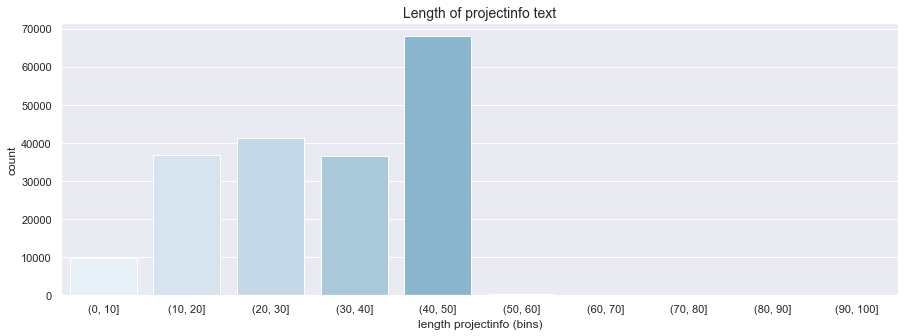

In [94]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x= df.slug_length_bins, data=df, palette="Blues")
plt.title('Length of projectinfo text', fontsize=14)
plt.xlabel("length projectinfo (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

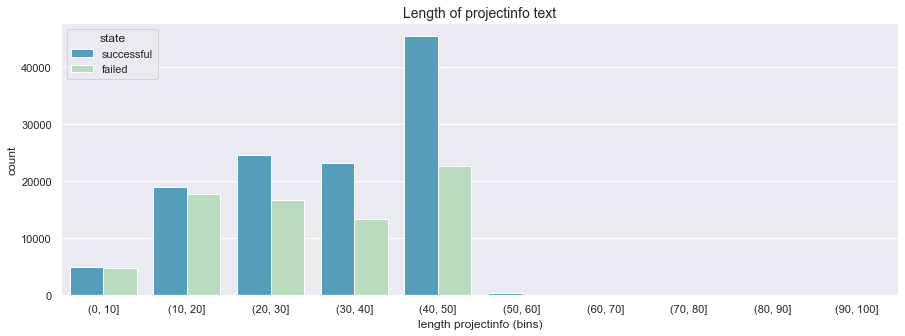

In [95]:
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x=df.slug_length_bins,data=df, hue='state', palette="GnBu_r")
plt.title('Length of projectinfo text', fontsize=14)
plt.xlabel("length projectinfo (bins)", fontsize=12)
plt.ylabel("count", fontsize=12);

**Comment** As we can see, the length of the slug is between of 1 up to 121 letters/symbols. At the first sight it seems there is no relationship between slug length and success. But we'll keep this in mind for future work.

# Next Step 

In the following notebook you can get more information about the final kept data for our modelling. As well as:
- check continous & category data
- label encoding
- distribution / skewed fratures
- feature scaling
- analyzing relationships / correlation matrix 
- model